In [1]:
### import libraries
import os
import cv2 as cv2
import numpy as np
import json  as json
import imutils
import math
from matplotlib import pyplot as plt

path_dataset = './dataset/'

def iread(img_path, resize_width=None):
    img = cv2.imread(path_dataset + img_path)
    if resize_width is not None:
        img = imutils.resize(img, width=resize_width)
    return img

def iread_edges(img_path, resize_factor=None):
    edges_rgb = iread(img_path)
    edges_white = cv2.cvtColor(edges_rgb, cv2.COLOR_BGR2GRAY)
    edges = cv2.bitwise_not(edges_white)
    
    if resize_factor is not None:
        new_shape = tuple(np.divide(edges.shape, resize_factor).astype(np.int32))[::-1]
        edges = cv2.resize(edges, new_shape, interpolation = cv2.INTER_CUBIC)
    return edges

def get_pts(img):
    row, col = img.nonzero()
    pts = np.column_stack((col, row)) # this are the points
    return pts
    
def iinfo(img):
    print("[IMAGE] height: {} x width: {} x channels: {} - data type: {}".format(
        img.shape[0], 
        img.shape[1], 
        (img.shape[2] if img.ndim > 2 else 0),
        img.dtype))


# CHECK INPUT IMAGE PTS (>6000 ~30 min execution)

HD/HD_01_canny.png] shape: (13662, 2)
[IMAGE] height: 235 x width: 900 x channels: 0 - data type: uint8
HD/HD_01_canny.png] shape: (9009, 2)
[IMAGE] height: 130 x width: 465 x channels: 0 - data type: uint8


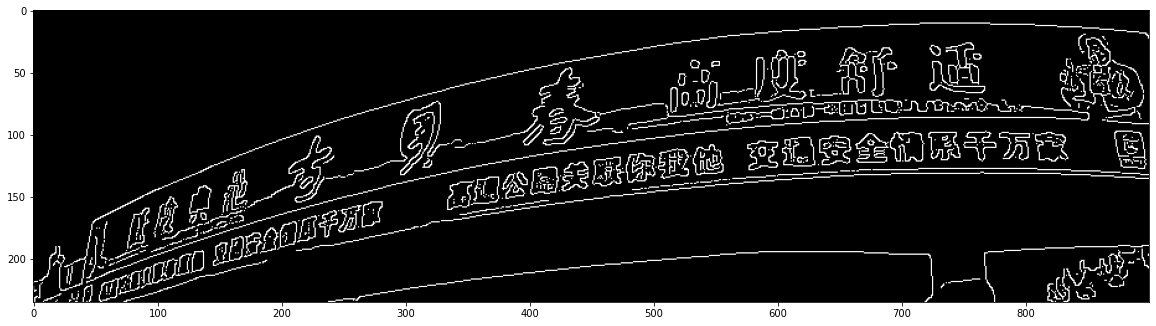

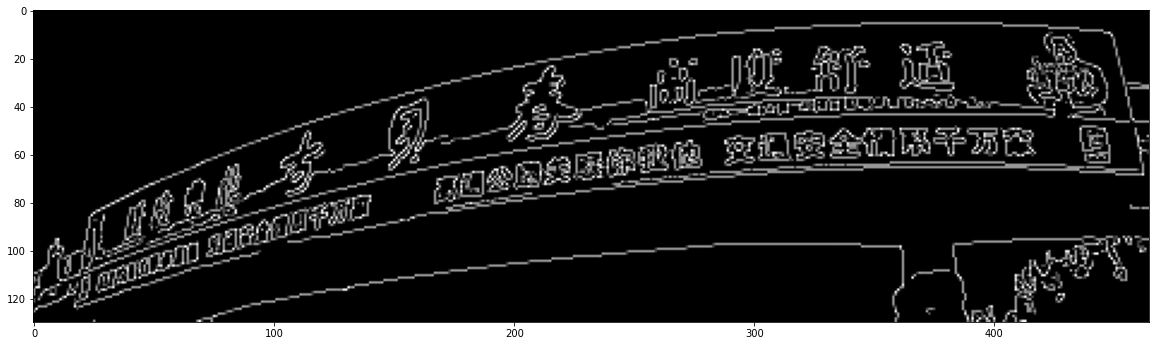

In [2]:
for p in ('HD/HD_01_canny.png',):
    img = iread_edges(p)
    img = img[:235, 100:1000]
    pts = get_pts(img)
    print("{}] shape: {}".format(p, pts.shape))
    
    plt.figure(figsize=(20,20))
    plt.imshow(img, cmap='gray')
    iinfo(img)

for p in ('HD/HD_01_canny.png',):
    img = iread_edges(p, resize_factor=2)
    img = img[:130, 50:515]
    pts = get_pts(img)
    print("{}] shape: {}".format(p, pts.shape))
    
    plt.figure(figsize=(20,20))
    plt.imshow(img, cmap='gray')
    iinfo(img)


# Get points

In [27]:
def print_points(pts):
    print("num of points: {}".format(pts.shape))
    plt.figure(figsize=(20,20))
    plt.scatter(pts[:, 0], pts[:, 1])
    plt.gca().invert_yaxis()
    plt.title('Input points')

# Get Minimal Set

In [4]:
def get_minimal_set(pts, number_minimal_pts, debug=False):
    this_pts = pts.copy()
    sample_pts = []
    sample_indices = []
    
    for i in range(number_minimal_pts):
        sample_i = np.random.randint(low=0, high=pts.shape[0] - 1)
        sample_indices.append(sample_i)
        sample_pts.append(this_pts[sample_i])
        this_pts = np.delete(this_pts, sample_i, 0)
    # convert to numpy arrays
    sample_pts     = np.array(sample_pts)
    sample_indices = np.array(sample_indices, dtype=int) 
    
    if debug:
        #print("sample set: \n\t{}\n sample_indices:\n\t {}\n new pts shape: \n\t{}".format(sample_pts, sample_indices, this_pts.shape))
        plt.figure(figsize=(10, 10))
        plt.gca().invert_yaxis()
        x = this_pts[:, 0]
        y = this_pts[:, 1]
        plt.plot(x, y, 'r.')
        
        sample_x = sample_pts[:, 0]
        sample_y = sample_pts[:, 1]
        plt.plot(sample_x, sample_y, 'g.')

    return sample_pts, this_pts, sample_indices

def get_parabola_from_set(coords, debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    parabola = T.fit(x, y, deg=2, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, parabola(x_axis), 'b')
    return parabola

def get_line_from_set(coords, roi_shape=(720, 1280), debug=False):
    x = coords[:, 0]
    y = coords[:, 1]
    
    try:
        line = T.fit(x, y, deg=1, full=False)
    except Exception as e:
        if np.min(x) == np.max(x):
            print ("coords have same x {}".format(coords))
            x = [] + [coords[0][0]] + [coords[0][0] + 0.0001] 
            line = T.fit(x, y, deg=1, full=False)
    
    if debug:
        plt.figure(figsize=(10, 10))
        plt.plot(x, y, 'r.')
    
    x_axis = np.linspace(0, roi_shape[1], roi_shape[1]) # roi dimension
    
    if debug:
        plt.plot(x_axis, line(x_axis), 'b')
    return line


# Get Model

In [5]:
import time
from numpy.polynomial import Chebyshev as T

def get_models_lines(pts, number_models, roi_shape=(720, 1280), number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):

        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        line_j            = get_line_from_set(sample_j, roi_shape=roi_shape, debug=debug) 
        models.append(line_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()    

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Models Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models
            
            
def get_models_parabola(pts, number_models, number_minimal_pts=2, debug=False, step_debug=1000, overwrite=False):
    models = list()
    # time utils
    start_time = time.time()
    step_time = time.time()
    
    for j in range(number_models):
        if len(pts) < number_minimal_pts:
            print('pts finished for sampling')
            break
        
        sample_j, new_pts , _   = get_minimal_set(pts, number_minimal_pts=number_minimal_pts, debug=debug)
        parabola_j        = get_parabola_from_set(sample_j, debug=debug) 
        models.append(parabola_j)

        if overwrite:
            pts = new_pts

        # step time end
        if j % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(j, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return models    

In [6]:
def print_model(model):
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'b')

def print_model_with_pts(model, pts):
    plt.scatter(pts[:, 0], pts[:, 1])
    x_axis = np.linspace(0, roi.shape[1], roi.shape[1]) # roi dimension
    plt.plot(x_axis, model(x_axis), 'r')

# Calculate Distance

In [7]:
from numpy import polynomial as P
import cupy as cp

def distance_line_pts(pts, line, roi_shape=(720,1280)):

    x = cp.array(pts[:, 0])
    y = cp.array(pts[:, 1])

    try:
        q, m = line.convert(kind=P.Polynomial).coef
    except Exception as e:
        print (e)
        q = line.convert(kind=P.Polynomial).coef
        m = 0
    a = -m
    b = 1
    c = -q
    qs = cp.array(np.repeat(c, len(x)))
    
    d = np.abs((cp.multiply(a, x) + cp.multiply(b, y) + qs) / cp.sqrt(a**2 + b**2))
    d[d>np.min(roi_shape)] = np.inf
    return d


# Preference Matrix


In [8]:
# Preference matrix utils
import seaborn as sn
import time

def print_preference_space(preference_matrix):
    preference_matrix_new = preference_matrix.copy()
    
    preference_matrix_new[preference_matrix==np.inf] = 0
    preference_matrix_new[preference_matrix<np.inf]  = 1
    
    x, y = preference_matrix_new.nonzero()

    plt.figure(figsize=(10, 10))
    plt.gca().invert_yaxis()
    plt.plot(x, y, 'r.')

def print_preference_matrix(matrix):
    fig, ax = plt.subplots(figsize=(15,15))         
    sn.heatmap(matrix, cmap="binary", yticklabels=False)
    #print_preference_space(matrix)

In [9]:
def get_preference_matrix(pts : np.array, models : np.array, roi_shape=(720,1280), limit=np.inf, step_debug=50, debug=False):
    
    # time utils
    start_time = time.time()
    
    x = pts[:, 0]
    y = pts[:, 1]
    matrix = cp.array([])
    
    step_time = time.time()
    i = 0
    for m in models:
        if i == limit:
            break
        
        if len(matrix) == 0 :
            matrix = distance_line_pts(pts, m, roi_shape=roi_shape)
        else:
            matrix = cp.column_stack([matrix, distance_line_pts(pts, m, roi_shape=roi_shape)])
        
        # step time end
        if i % step_debug == 0:
            end_time = time.time()
            elapsed = end_time - step_time
            print("{}] took: {}".format(i, time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
            step_time = time.time()
        i += 1
        
    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Preference Matrix Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return matrix

def print_matrix_info(matrix):
    mean    = matrix[matrix < np.inf].mean()
    minimum = np.min(matrix[matrix < np.inf])
    maximum = np.max(matrix[matrix < np.inf])
    
    num_inf = np.sum((matrix==np.inf).ravel())
    num_min = np.sum((matrix == minimum).ravel())
    num_max = np.sum((matrix == maximum).ravel())
    
    below_avg = np.sum((matrix < mean).ravel())
    above_avg = np.sum((matrix > mean).ravel()) -  num_inf
    
    print("mean:\t {}".format(mean))
    print("min:\t {}".format(minimum))
    print("max:\t {}".format(maximum))
    print("num of total:\t {}".format(matrix.shape[0]))
    print("num of dropped:\t {}".format(num_inf))
    print("num of minimum:\t {}".format(num_min))
    print("num of maximum:\t {}".format(num_max))
    print("num of < average:\t {}".format(below_avg))
    print("num of > average:\t {}".format(above_avg))
    
def print_model_info_matrix(matrix, model_i):
    col = matrix[:, model_i]
    if len(col) == 0:
        print("{} model] pts: 0 num of min: 0, num of max: 0 min: np.inf, max: np.inf".format(model_i))
        return
    num_pts = np.sum((col < np.inf).ravel())

    mean    = col[col < np.inf].mean()
    minimum = np.min(col[col < np.inf])
    maximum = np.max(col[col < np.inf])
    
    num_min = np.sum((col == minimum).ravel())
    num_max = np.sum((col == maximum).ravel())

    print("{} model] pts: {} num of min: {}, num of max: {} min: {}, max: {}".format(model_i, num_pts, num_min, num_max, minimum, maximum))

def model_num_pts(col):
    return np.sum((col < np.inf).ravel())

def model_top_ten(matrix):
    return np.argsort(np.apply_along_axis(model_num_pts, 0, matrix))[::-1][:10]    

# Get Distance Matrix

In [10]:
from scipy.spatial.distance import jaccard, pdist, squareform
from sklearn.metrics import pairwise_distances

def get_distance_matrix(matrix, thr):
    start_time = time.time()
    
    truncated = cp.zeros(shape=matrix.shape,dtype=np.uint8)
    truncated[matrix<thr] = 1
    
    # calculate distance between rows
    truncated = cp.asnumpy(truncated)
    distance_matrix = pdist(truncated, metric='jaccard')
    distance_matrix = squareform(distance_matrix)

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Distance Matrix Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return distance_matrix

def get_distance_matrix_multithreaded(matrix, thr):
    start_time = time.time()
    
    truncated = cp.zeros(shape=matrix.shape,dtype=np.uint8)
    truncated[matrix<thr] = 1
    
    # calculate distance between rows
    truncated = cp.asnumpy(truncated)
    distance_matrix = pairwise_distances(truncated, metric='jaccard', n_jobs=-1)
    #distance_matrix = squareform(distance_matrix)

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Distance Matrix Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")
    return distance_matrix

def print_distance_matrix(matrix):
    
    # mask because it is simmetrical
    corr = np.corrcoef(np.random.randn(matrix.shape[0], 200))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    
    
    fig, ax = plt.subplots(figsize=(15,15))
    sn.heatmap(matrix, cmap="binary", mask=mask, vmax=1, vmin=0, xticklabels=False, yticklabels=False)

# Get Distance Clusters

In [11]:
from sklearn.cluster import DBSCAN

def get_clusters_from_distance(distance_matrix, eps, min_samples=5):
    start_time = time.time()

    db = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(distance_matrix)
    pts_clusters = db.fit_predict(distance_matrix)
    clusters_label = np.unique(pts_clusters)
    
    clusters = {}
    for l in clusters_label:
        clusters.update({l: np.where(pts_clusters == l)[0]})

    # time utils
    end_time = time.time()
    elapsed = end_time - start_time
    print("===============================================")
    print("Clusters Completed! total time: {}".format(time.strftime("%H h %M m %S s", time.gmtime(elapsed))))
    print("===============================================")

    return clusters, clusters_label, pts_clusters

def print_cluster(cluster_pts, pts, label, color="b", xlimit=2000, ylimit=400):
    coords = np.take(pts, cluster_pts, axis=0)
    plt.figure(figsize=(10, 10))
    plt.xlim(0, xlimit)
    plt.ylim(ylimit, 0)
    plt.scatter(coords[:, 0], coords[:, 1], 1, c=color)
    plt.title('Cluster {}'.format(label))


# Print Output

In [62]:
import matplotlib.colors as colors
import random
base_colors = list(colors.BASE_COLORS)
del base_colors[2]
other_colors = list(colors.cnames.keys())
random.shuffle(other_colors)

all_colors = base_colors + other_colors

def print_output(roi, clusters, pts):
    cluster_labels = list(clusters.keys())

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(roi, cmap='gray')
    
    for i in range(len(cluster_labels)):
        l = cluster_labels[i]

        if i > len(all_colors):
            color = all_colors[i%len(all_colors)]
        else:
            color = all_colors[i] if l !=-1 else 'r'
        
        coords = np.take(pts, clusters[l], axis=0)
        ax.scatter(coords[:, 0], coords[:, 1], 1, c=color)

def print_output_no_roi(clusters, pts, label, white=True):
    cluster_labels = list(clusters.keys())

    fig, ax = plt.subplots(figsize=(20, 20))
    plt.gca().invert_yaxis()
    plt.title(label)
    
    for i in range(len(cluster_labels)):
        l = cluster_labels[i]

        if i >= len(all_colors):
            color = all_colors[i%len(all_colors)]
        else:
            color = all_colors[i] if l !=-1 else 'r'
        
        coords = np.take(pts, clusters[l], axis=0)
        if white is False:
            ax.set_facecolor('black')
        
        ax.scatter(coords[:, 0], coords[:, 1], 1, c=color)
        
def print_compare(img_path, clusters, pts, region_shape=[0, None, 0, None], resize_factor=None):
    cluster_labels = list(clusters.keys())

    hough_image  = iread(img_path + ".png")
    output_image = iread(img_path + "_normal.png")
    img_shape = (hough_image.shape[0], hough_image.shape[1])
    
    if resize_factor is not None:
        new_shape = tuple(np.divide(img_shape, resize_factor).astype(np.int32))[::-1]
        hough_image  = cv2.resize(hough_image, new_shape, interpolation = cv2.INTER_CUBIC)
        output_image = cv2.resize(output_image, new_shape, interpolation = cv2.INTER_CUBIC)
    
    # cut hough image
    if region_shape is not None:
        x_start = region_shape[0]
        x_end   = region_shape[1]
        y_start = region_shape[2]
        y_end   = region_shape[3]
        
        new_hough_image = output_image.copy()
        new_hough_image[y_start:y_end, x_start:x_end] = hough_image[y_start:y_end, x_start:x_end]
        
    
    fig, ax = plt.subplots(2,1, figsize=(20, 20))
    
    # print our points
    ax[0].imshow(output_image)
    for i in range(len(cluster_labels)):
        l = cluster_labels[i]
        color = all_colors[i] if l !=-1 else 'r'
        
        coords = np.take(pts, clusters[l], axis=0)
        ax[0].scatter(coords[:, 0] + x_start, coords[:, 1] + y_start, 1, c=color)
    
    # print hough points
    ax[1].imshow(new_hough_image)

# RUN

num of points: (6000, 2)


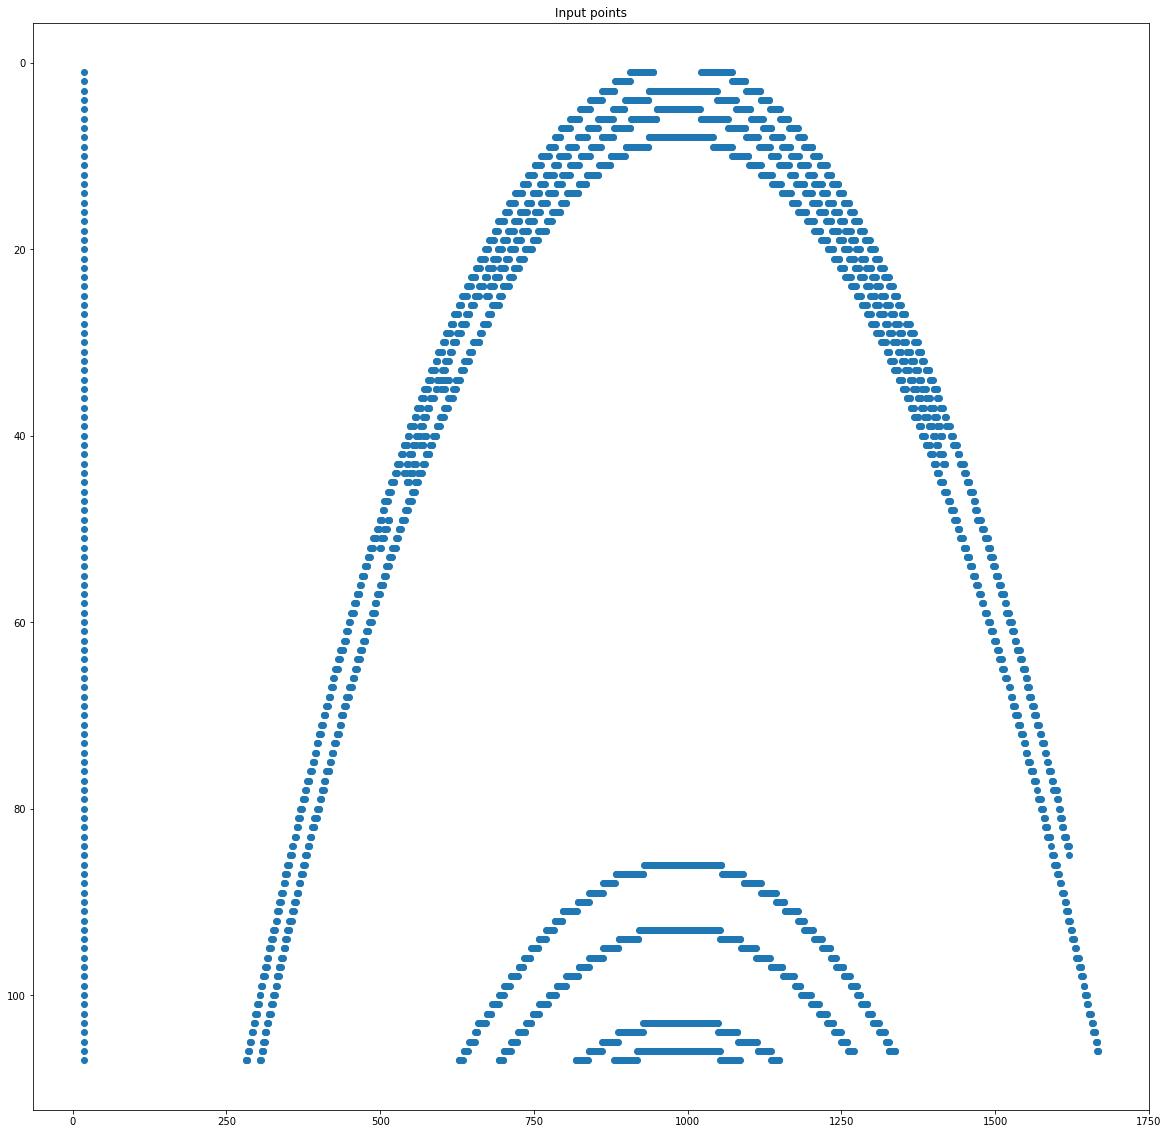

In [38]:
# get image
img_path = 'FullHD/18'
img = iread_edges('{}_canny.png'.format(img_path), resize_factor=None)
pts = get_pts(img)
pts = pts[:6000]

print_points(pts)


In [39]:
# get models
models = get_models_lines(pts, pts.shape[0]*2, roi_shape=img.shape, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, roi_shape=img.shape, step_debug=1000, debug=False)

0] took: 00 h 00 m 00 s
coords have same x [[1292   19]
 [1292   27]]
1000] took: 00 h 00 m 00 s
2000] took: 00 h 00 m 00 s
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 02 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expec

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 26 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 26 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 25 s
Clusters Completed! total time: 00 h 00 m 00 s


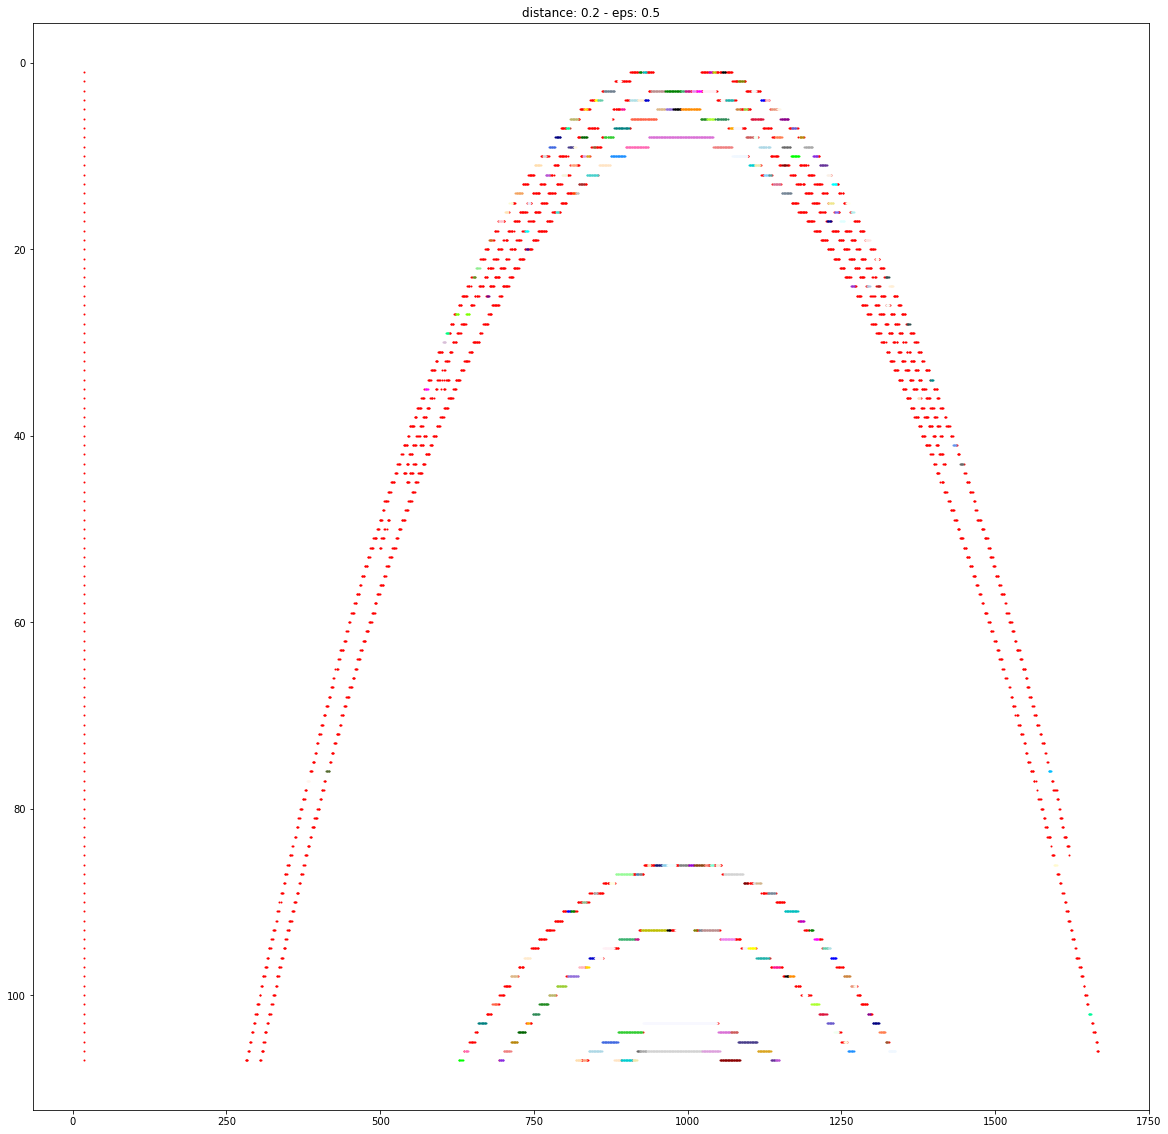

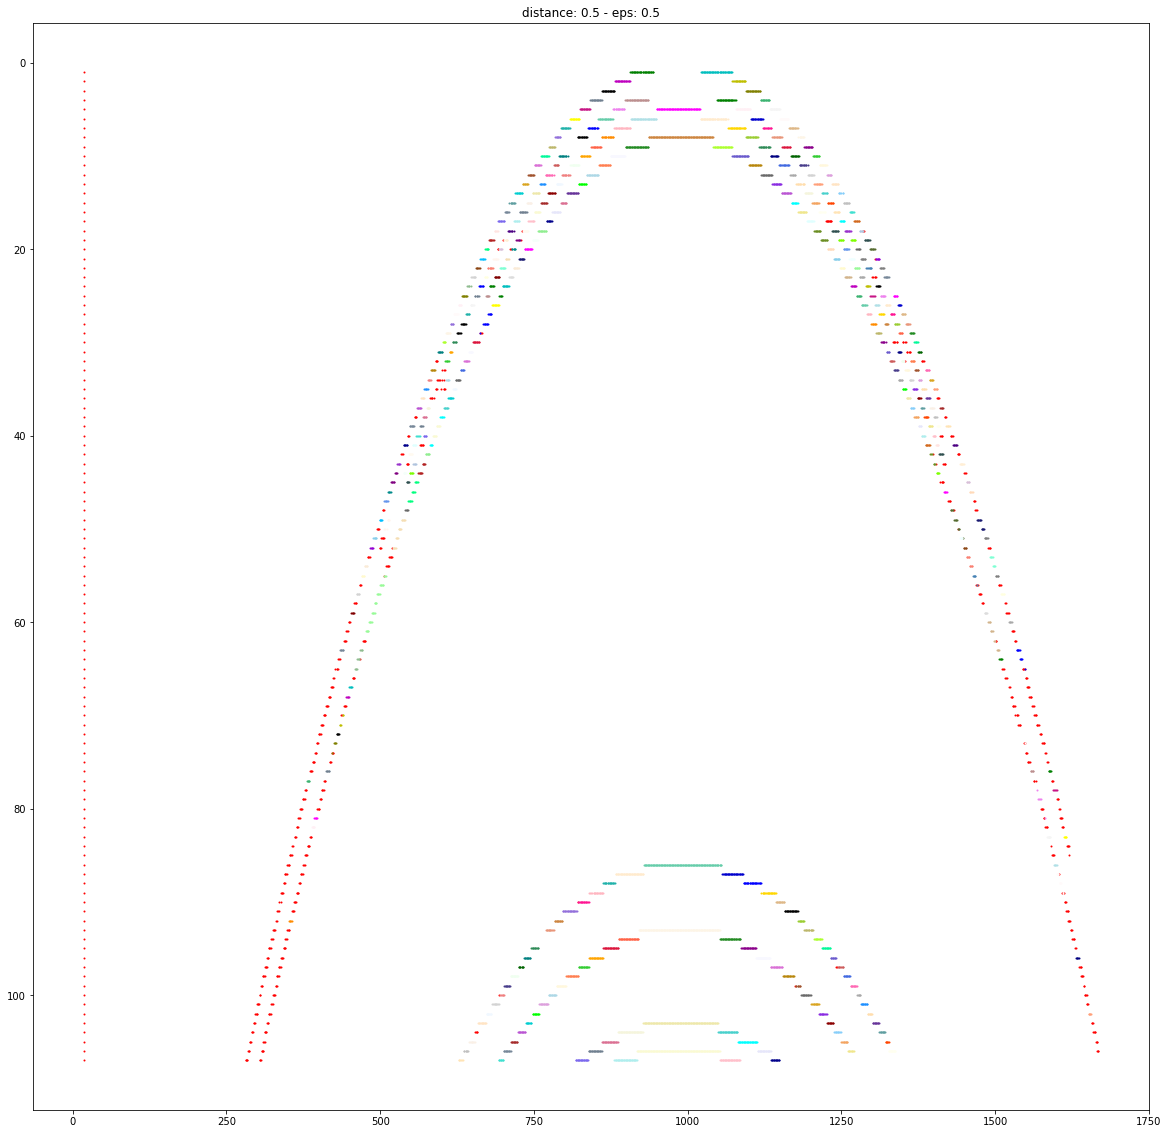

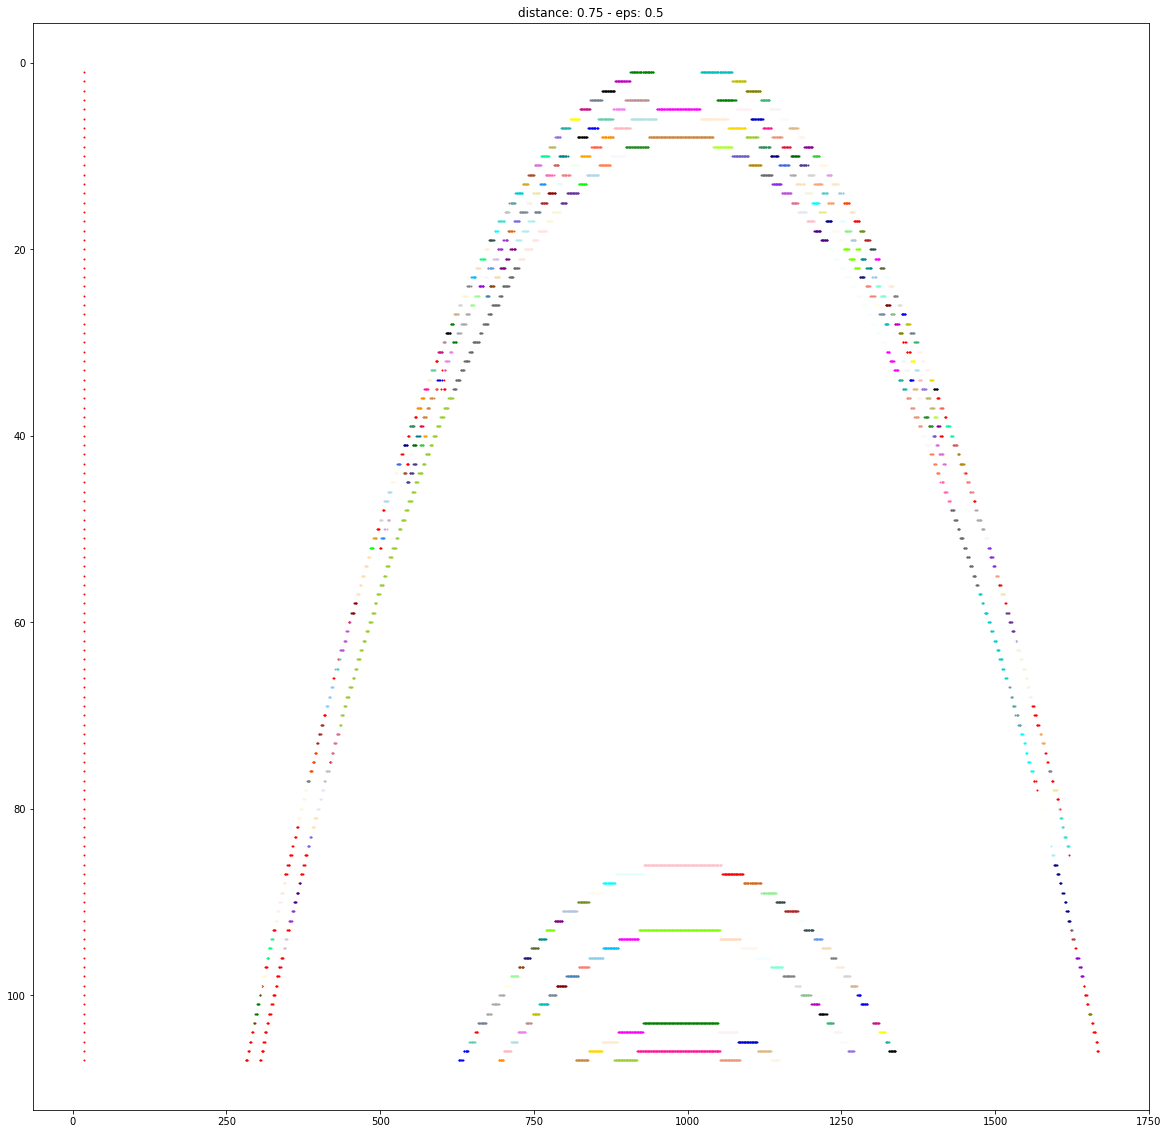

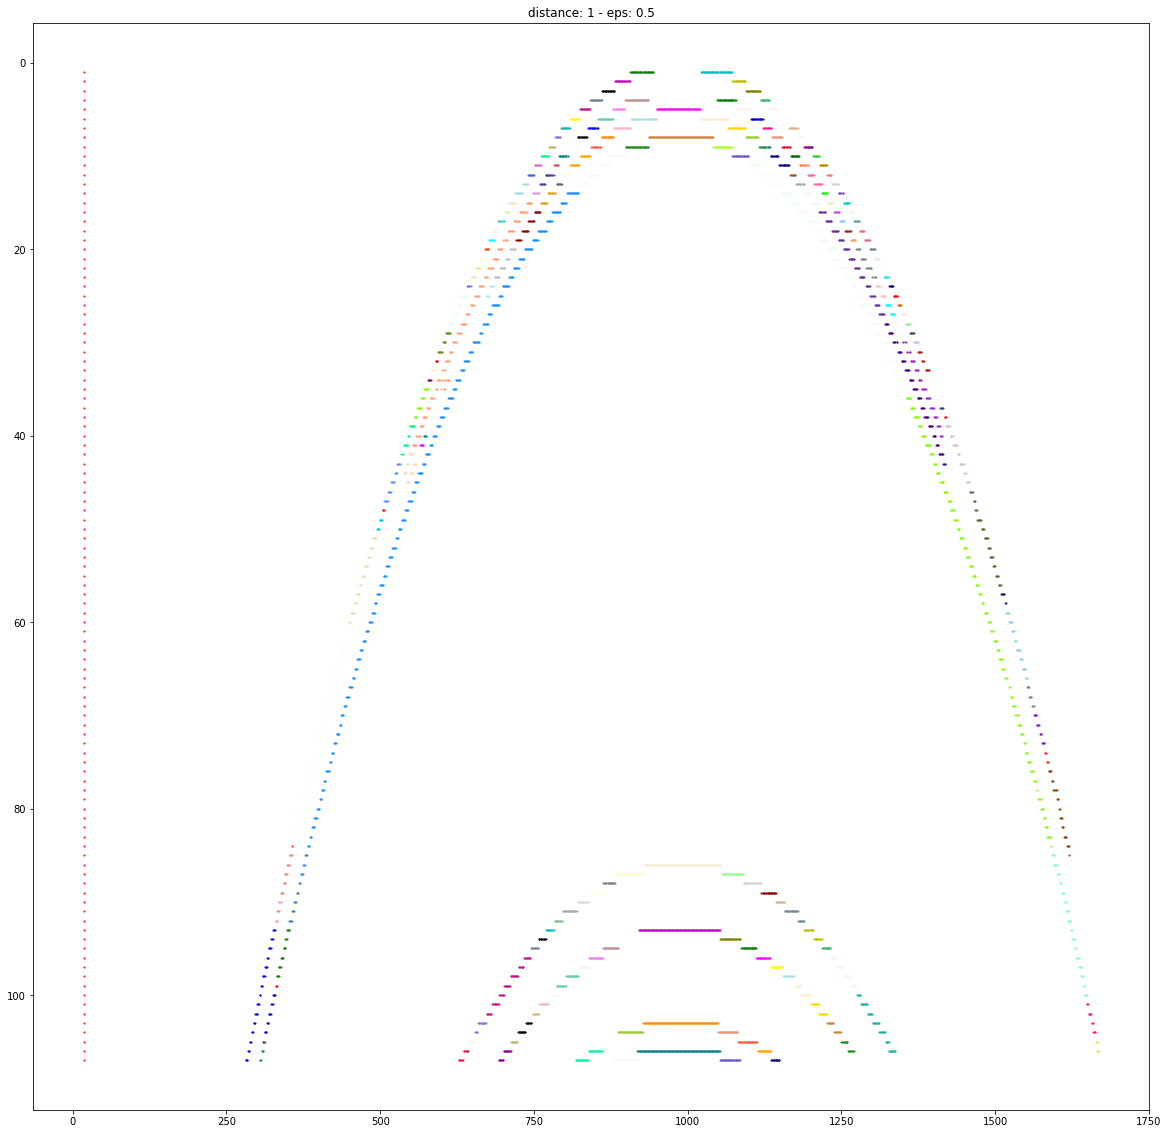

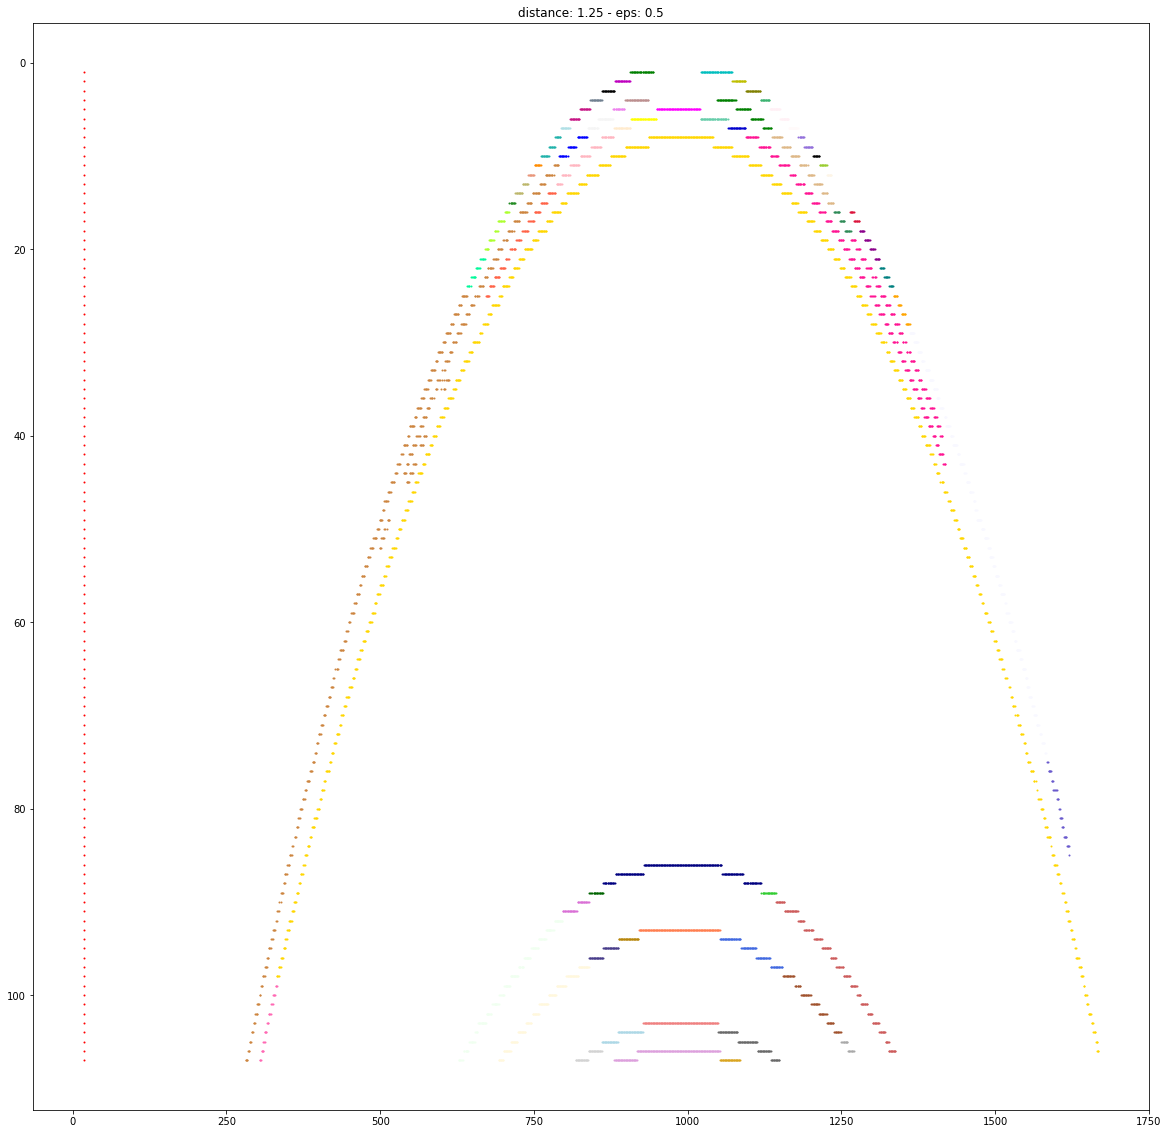

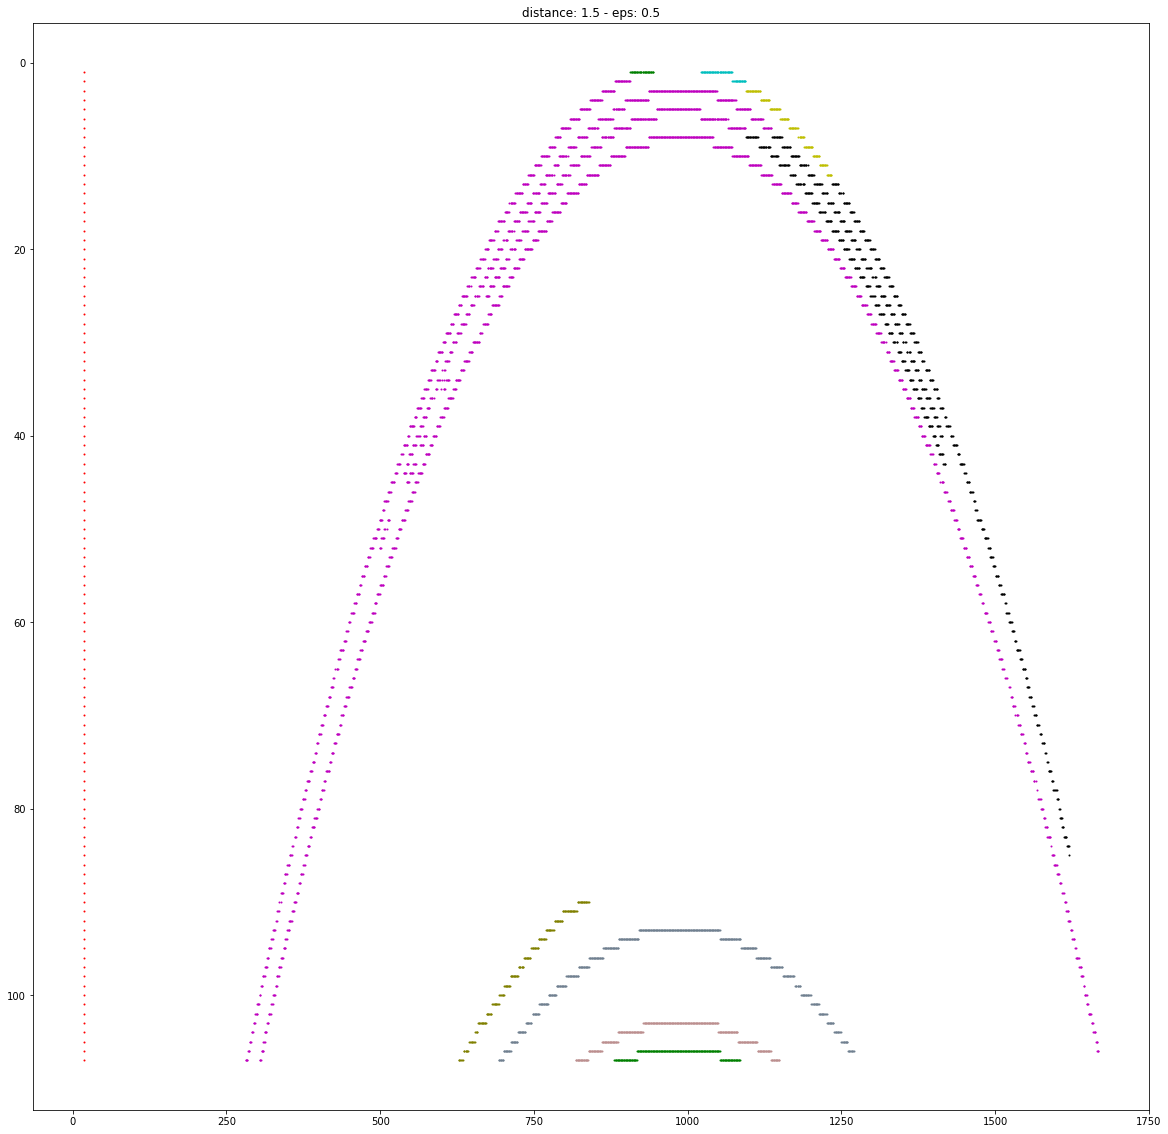

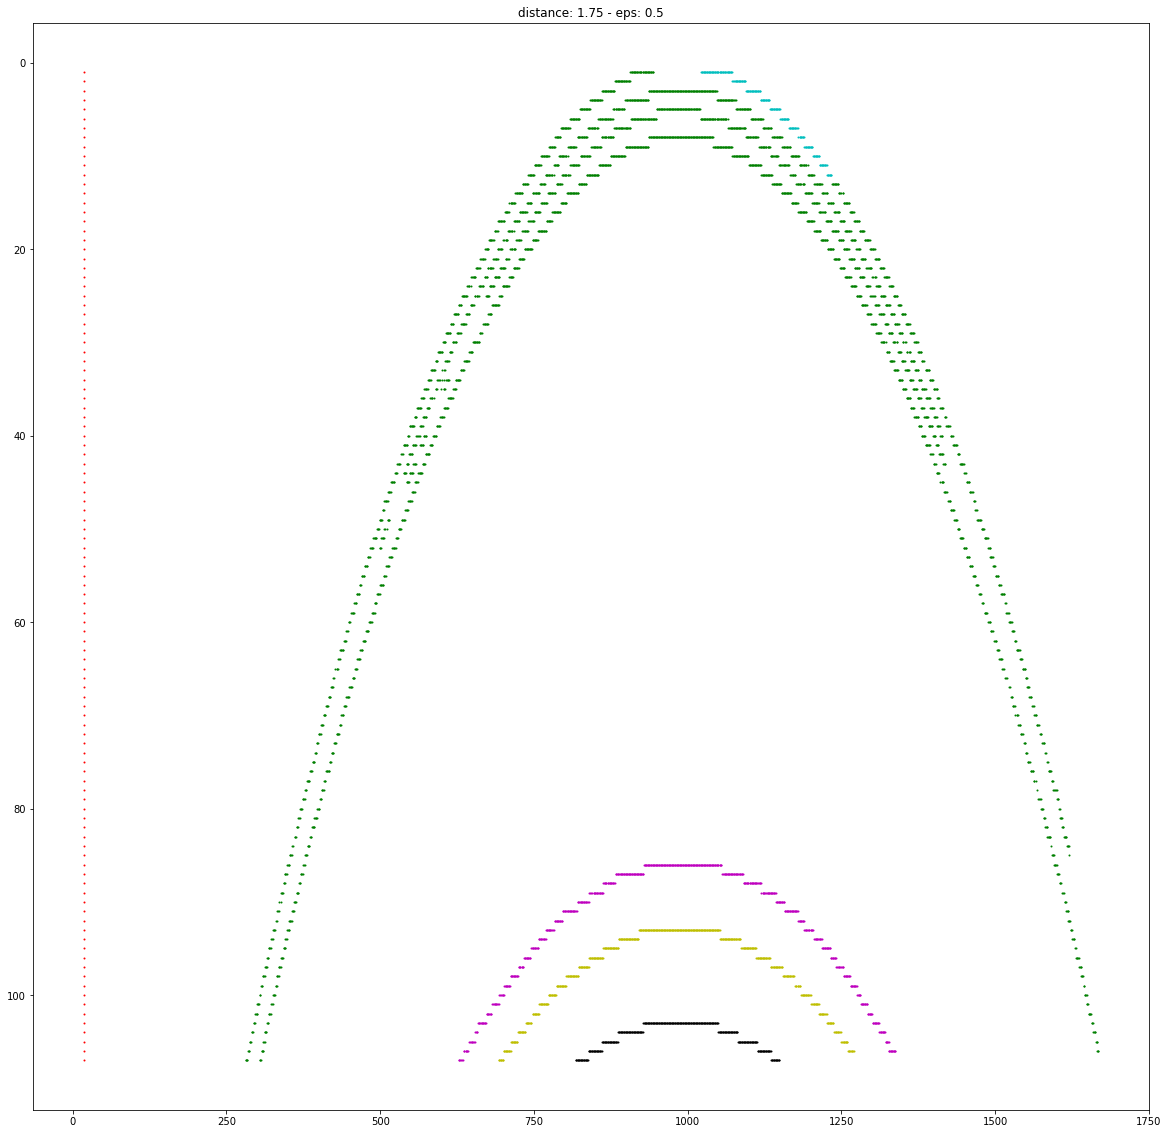

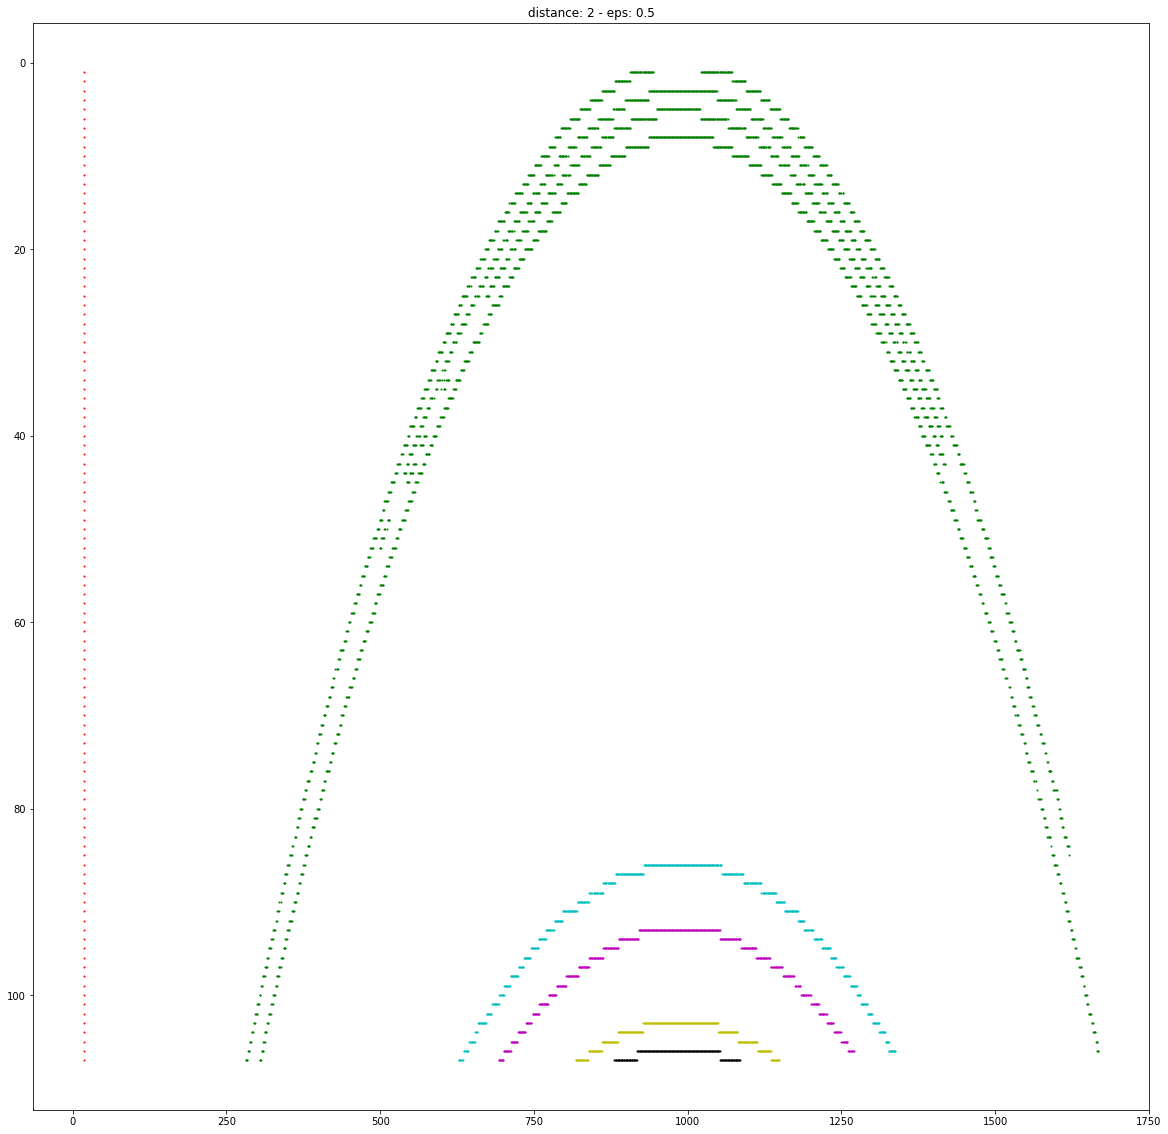

In [58]:
# get distance matrix - threshold = 2
for d in [0.2, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]:
    distance_matrix = get_distance_matrix_multithreaded(matrix, d)
    eps = 0.5
    clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, eps)
    print_output_no_roi(clusters, pts, 'distance: {} - eps: {}'.format(d, eps))

(3294, 2)
0] took: 00 h 00 m 00 s
coords have same x [[ 94  71]
 [ 94 100]]
coords have same x [[137 242]
 [137 210]]
coords have same x [[ 91 248]
 [ 91 186]]
coords have same x [[103 110]
 [103 190]]
coords have same x [[ 24 238]
 [ 24 234]]
1000] took: 00 h 00 m 00 s
coords have same x [[ 88 160]
 [ 88 243]]
coords have same x [[ 51 257]
 [ 51 255]]
coords have same x [[127 196]
 [127 239]]
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
Preference Matrix Completed! total time: 00 h 00 m 01 s


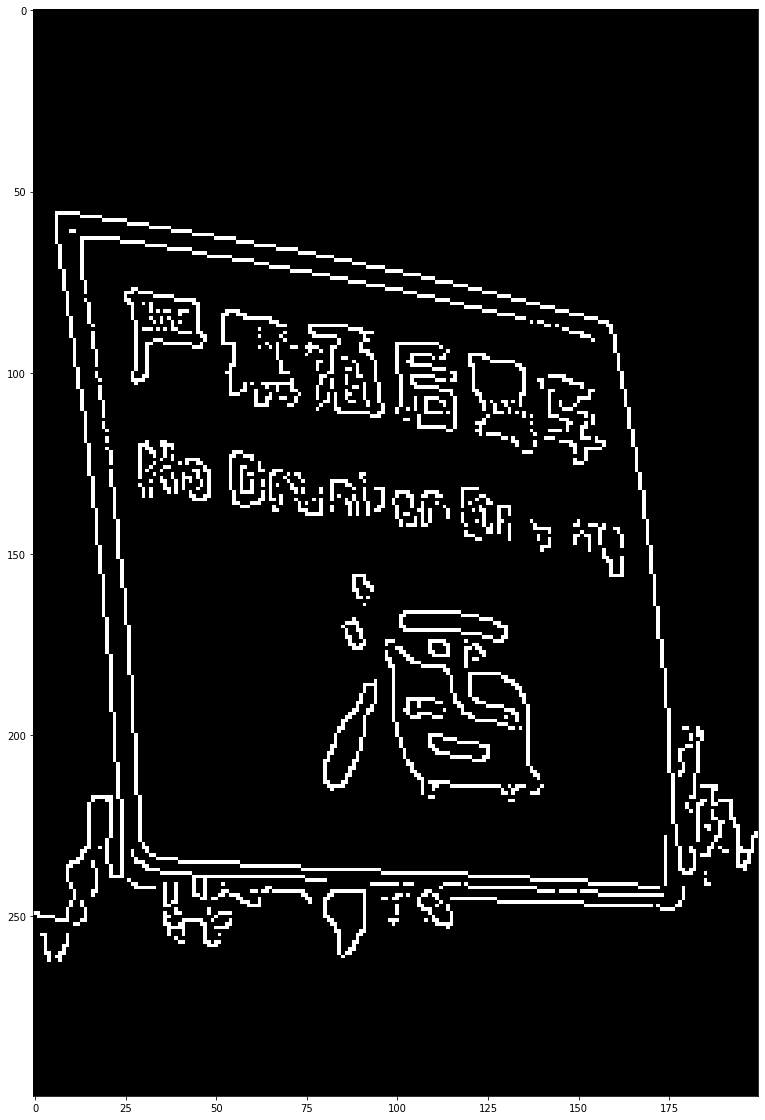

In [60]:
img_02 = dict(path='HD/HD_02', x_start=1000, x_end=1200, y_start=100, y_end=400, resize_factor=None)
dataset = [img_02]

for d in dataset:
    
    # get image
    img_path = d['path']
    x_start = d['x_start']
    x_end   = d['x_end']
    y_start = d['y_start']
    y_end   = d['y_end']
    resize_factor = d['resize_factor']
    
    img = iread_edges('{}_canny.png'.format(img_path), resize_factor=resize_factor)
    
    plt.figure(figsize=(20,20))
    img = img[y_start:y_end, x_start:x_end]
    plt.imshow(img, cmap='gray')
    pts = get_pts(img)

    print(pts.shape)
    
    
    # get models
    models = get_models_lines(pts, pts.shape[0]*5, roi_shape=img.shape, overwrite=True)

    # get preference matrix
    matrix = get_preference_matrix(pts, models, roi_shape=img.shape, step_debug=1000, debug=False)


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 04 s
Clusters Completed! total time: 00 h 00 m 00 s


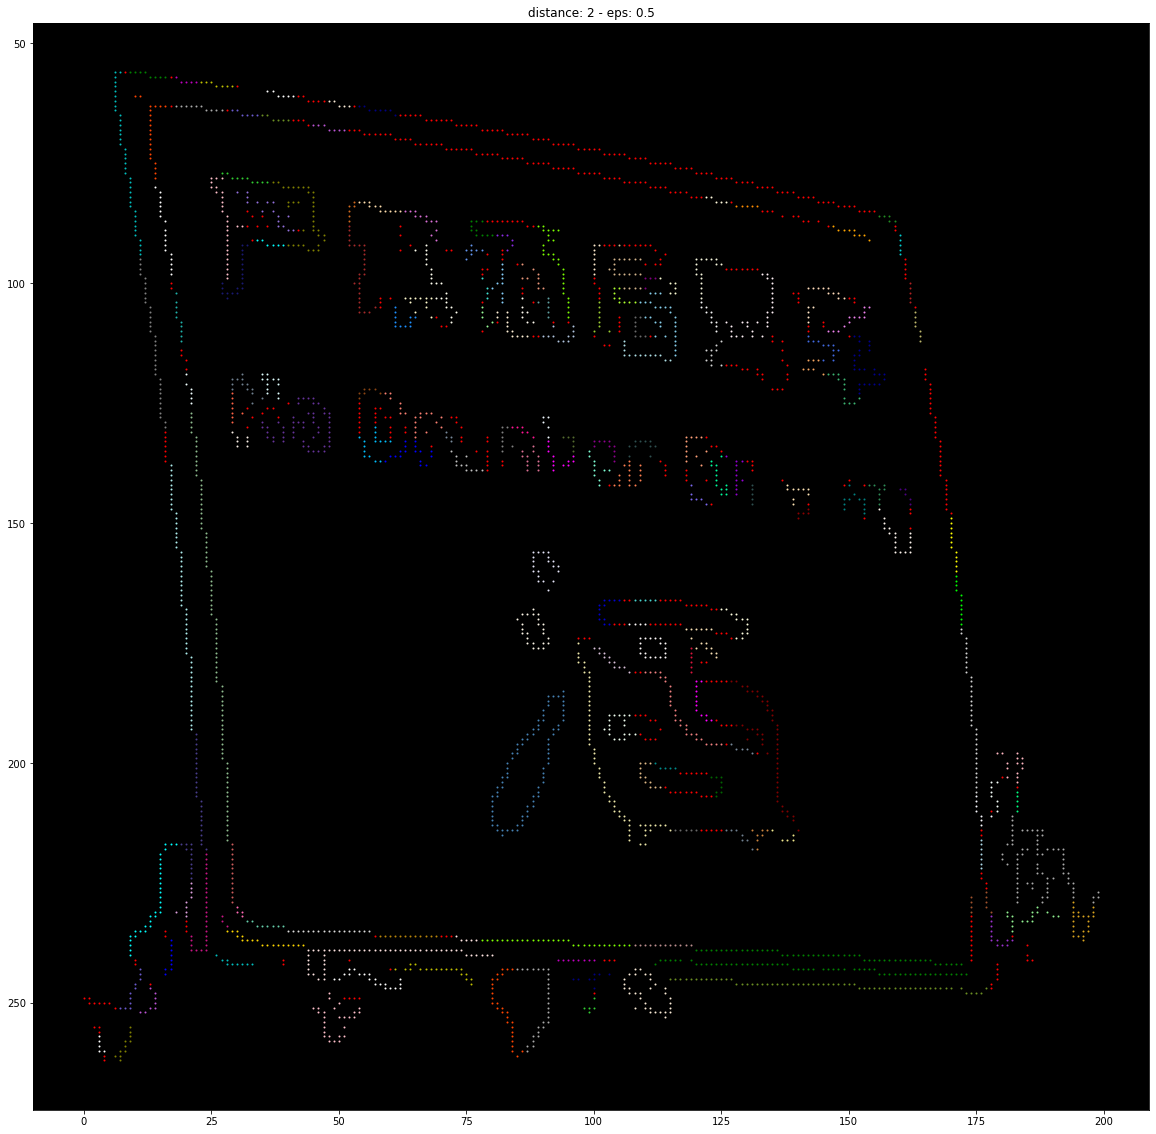

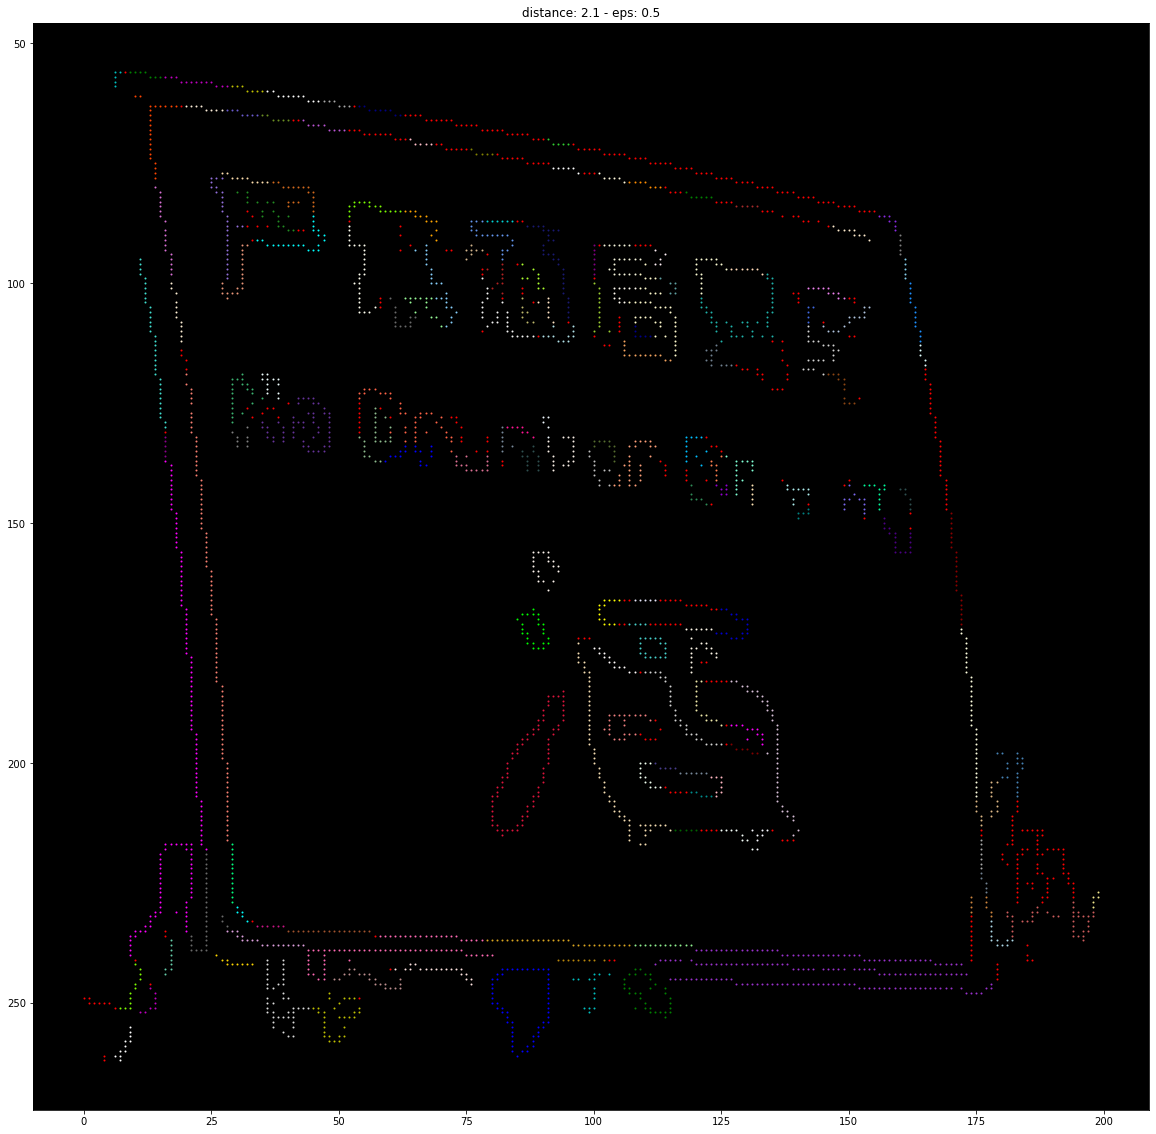

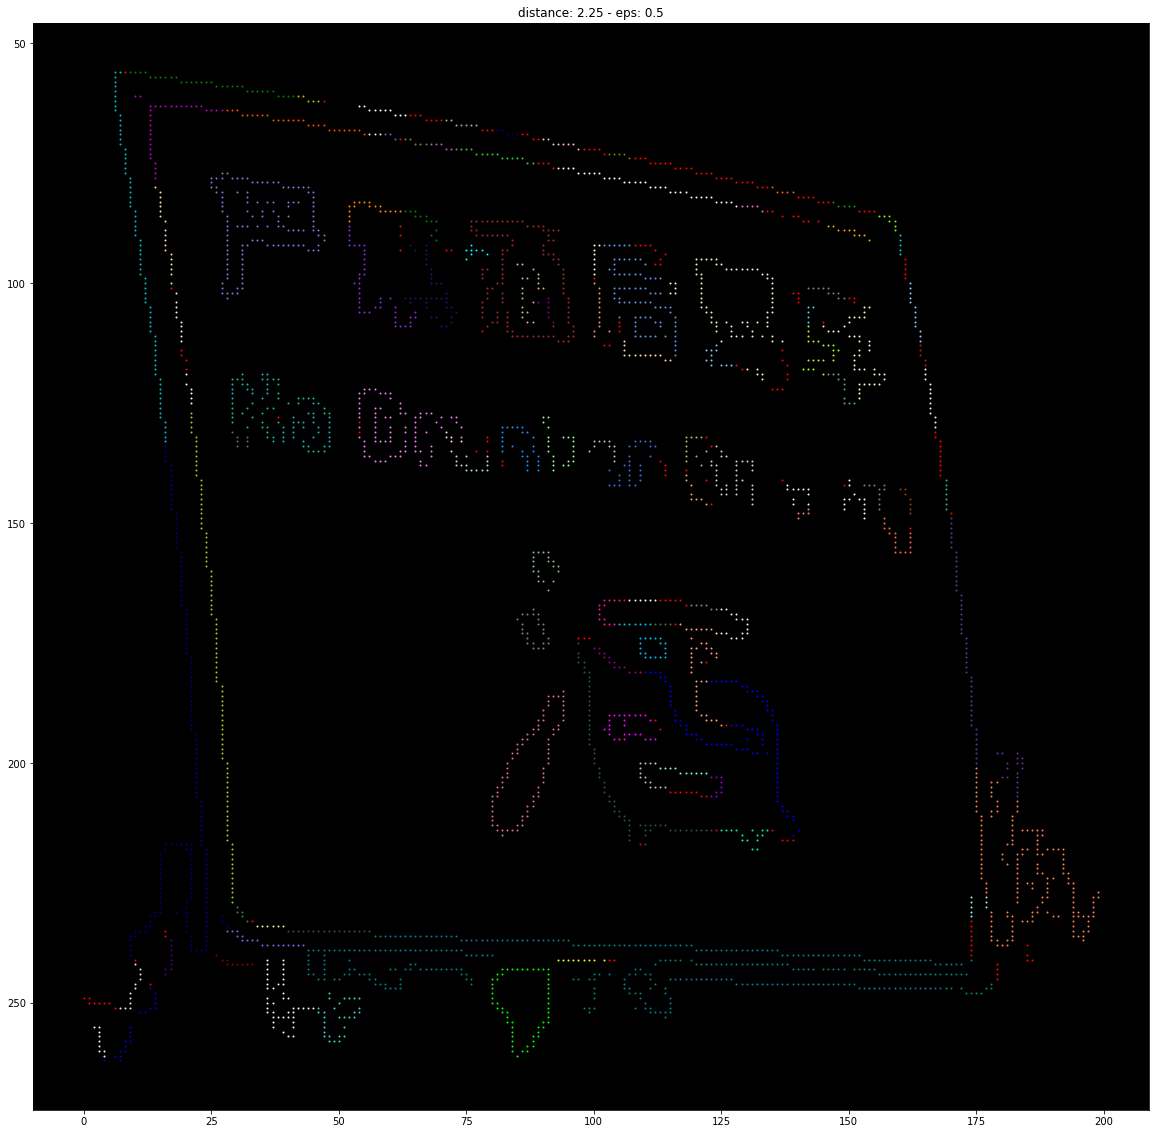

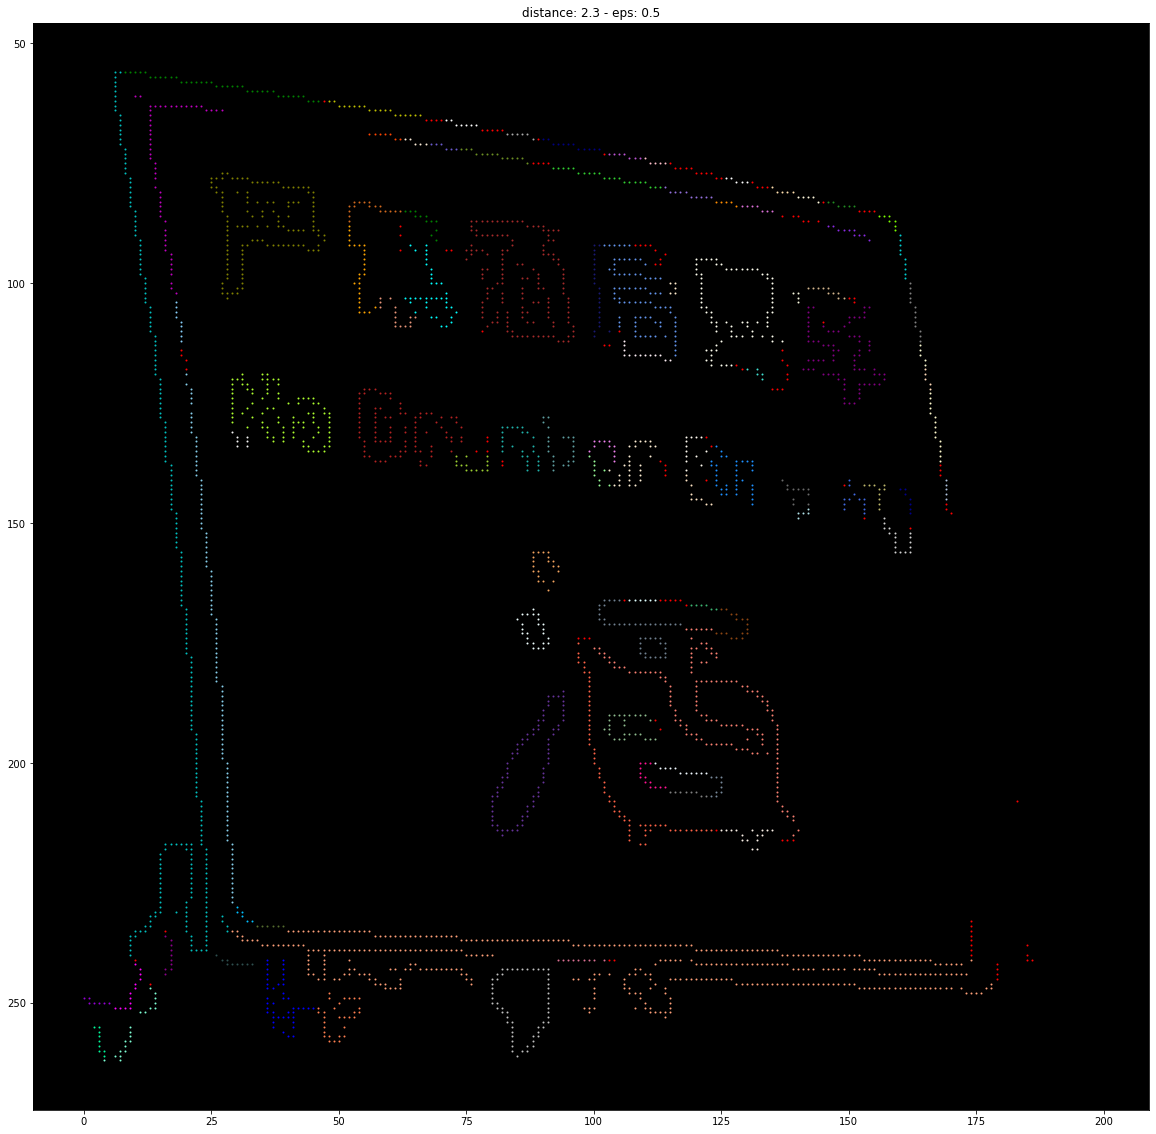

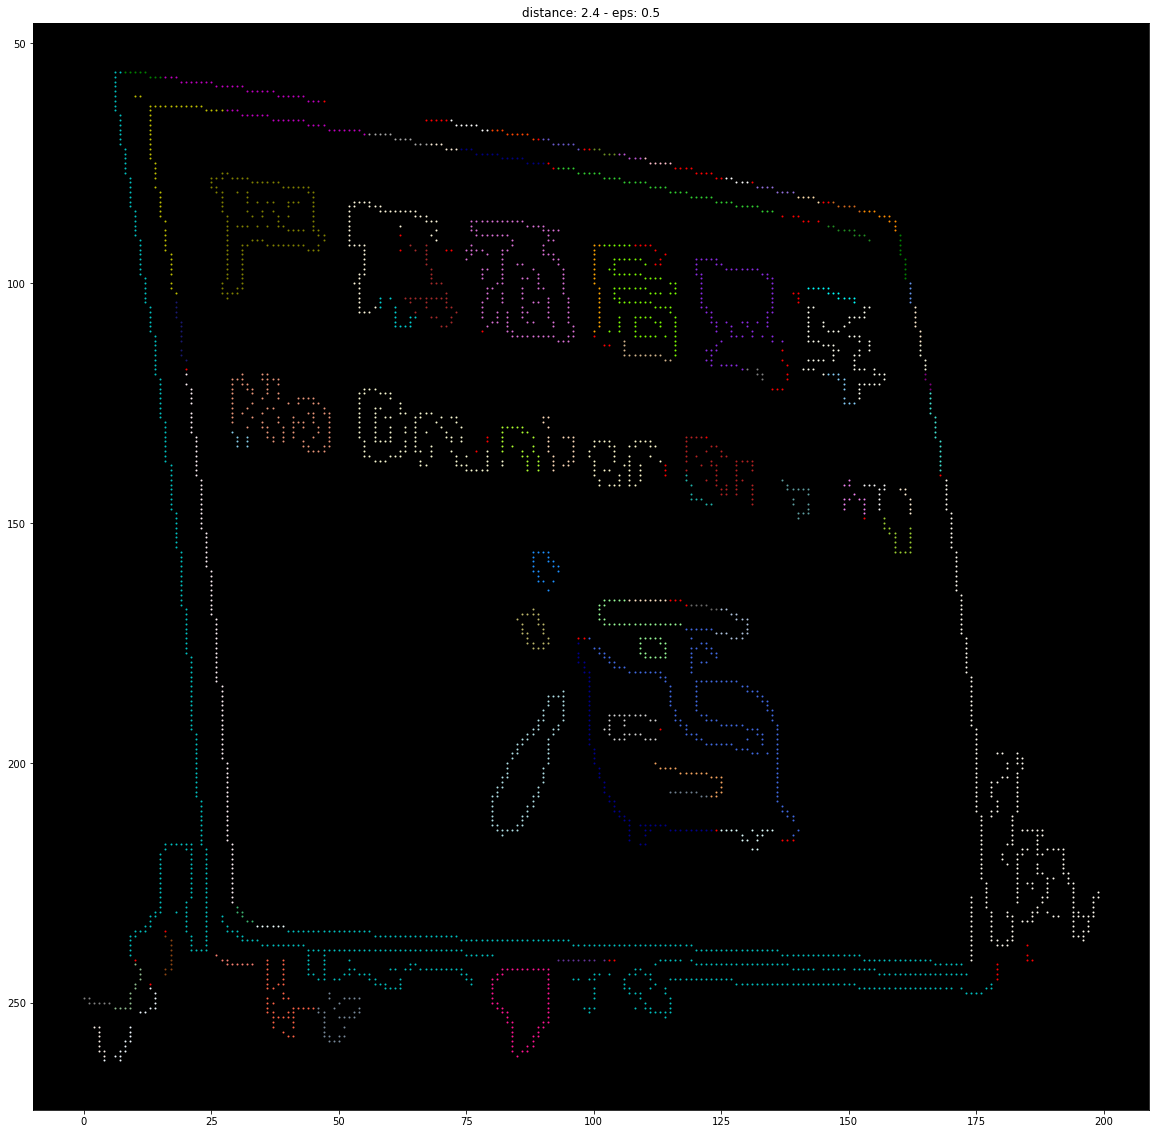

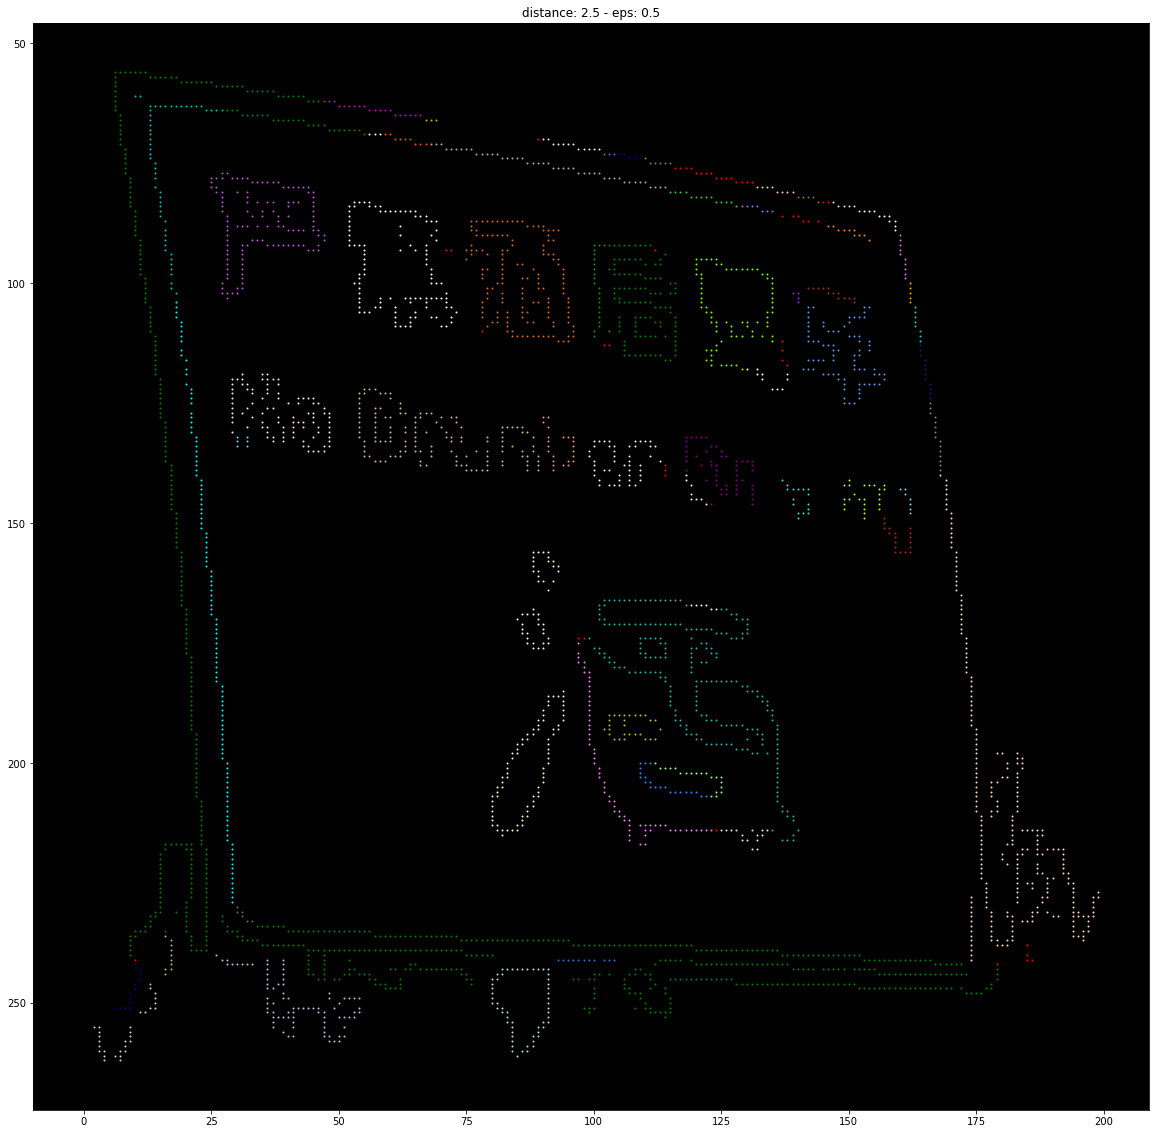

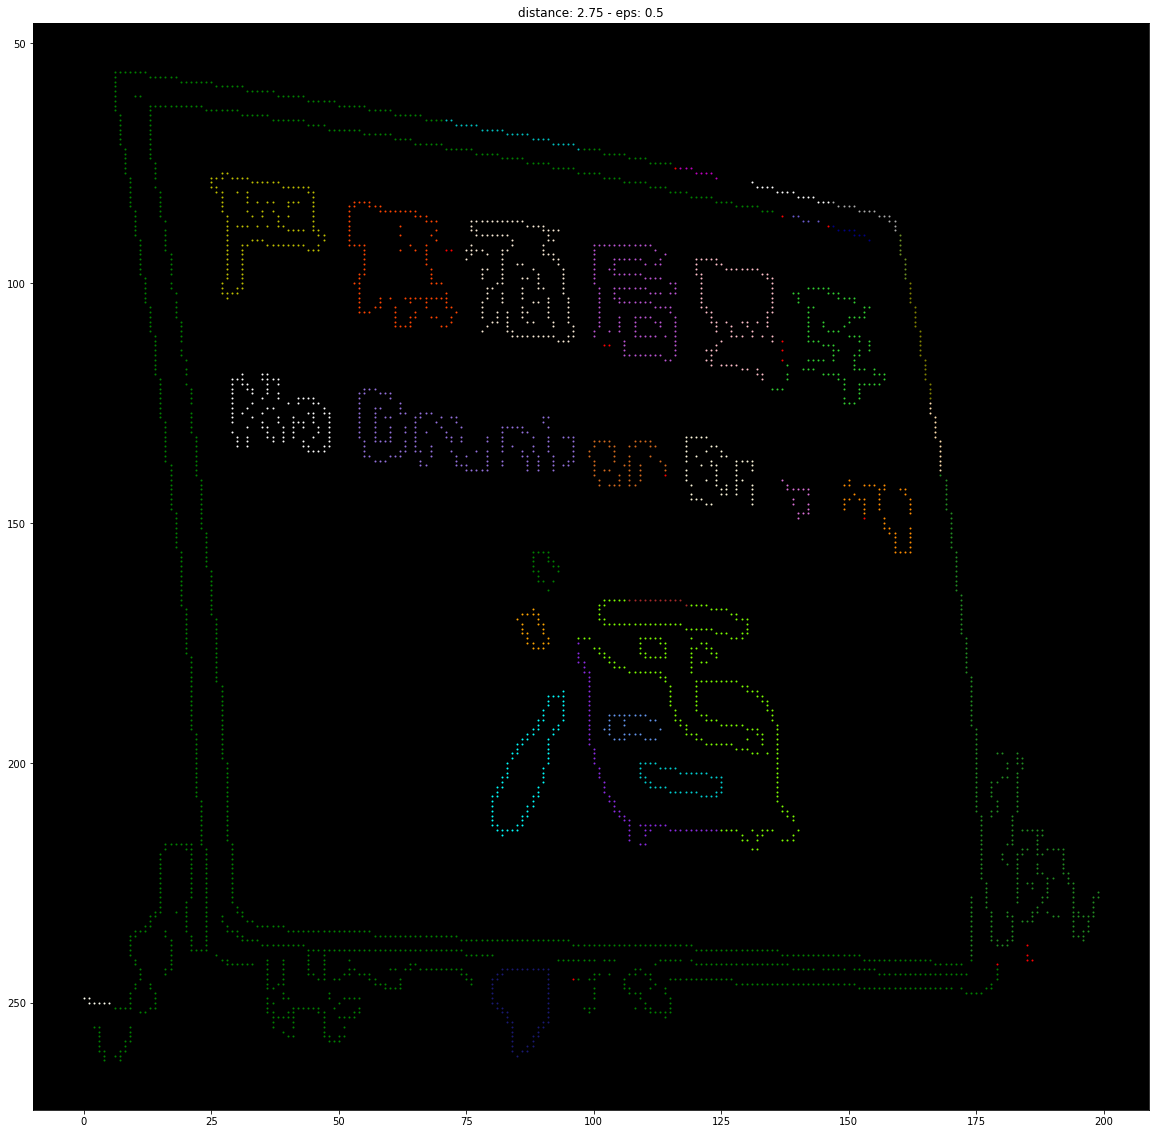

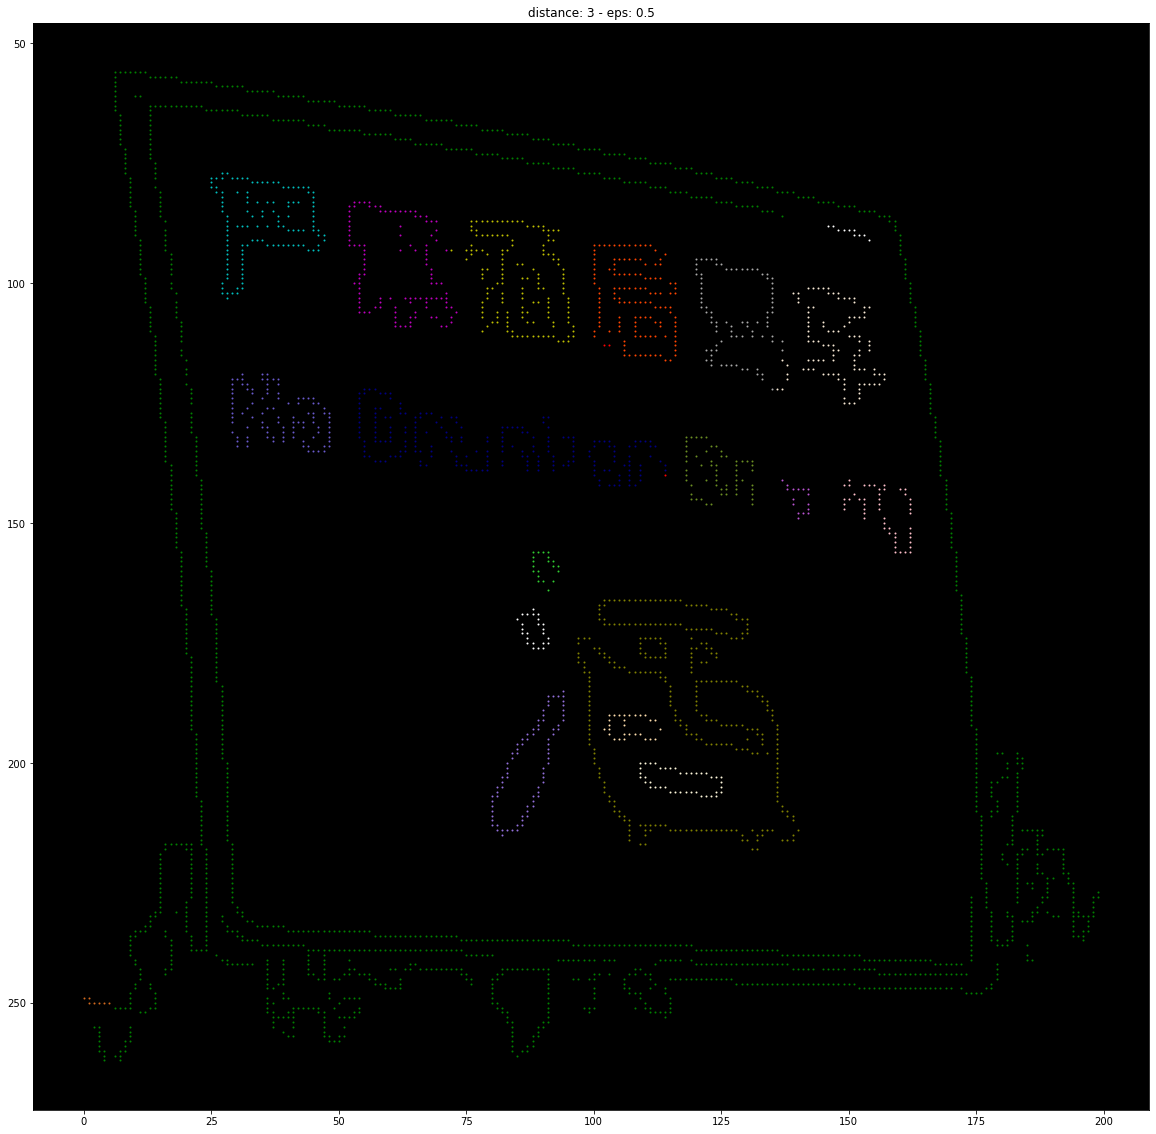

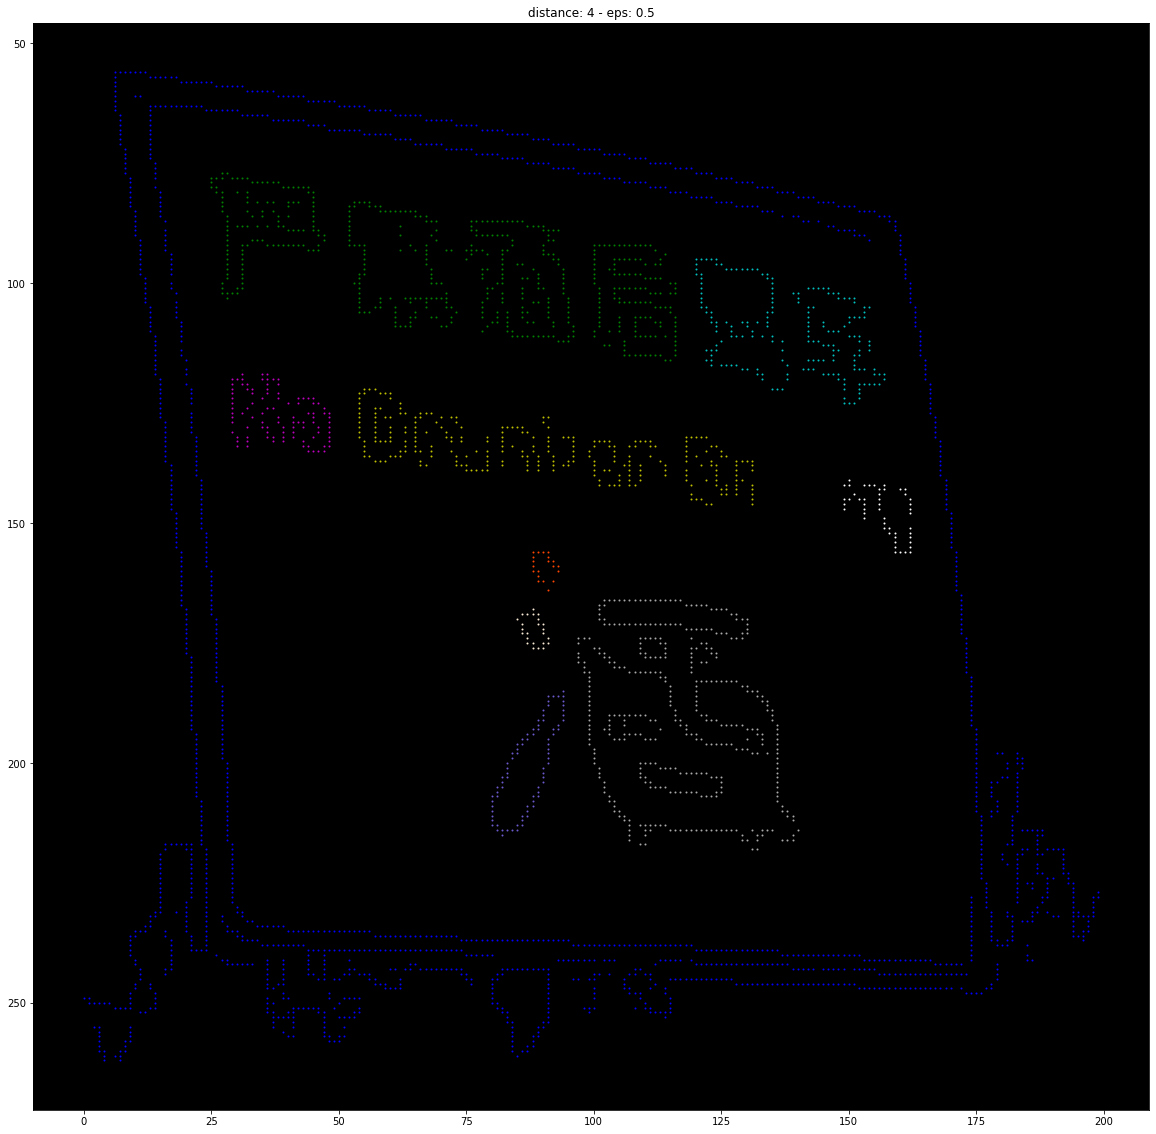

In [65]:
# get distance matrix - threshold = 2
for d in [2, 2.1, 2.25, 2.3, 2.4, 2.5, 2.75, 3, 4]:
    distance_matrix = get_distance_matrix_multithreaded(matrix, d)
    eps = 0.5
    clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, eps)
    print_output_no_roi(clusters, pts, 'distance: {} - eps: {}'.format(d, eps), white=False)

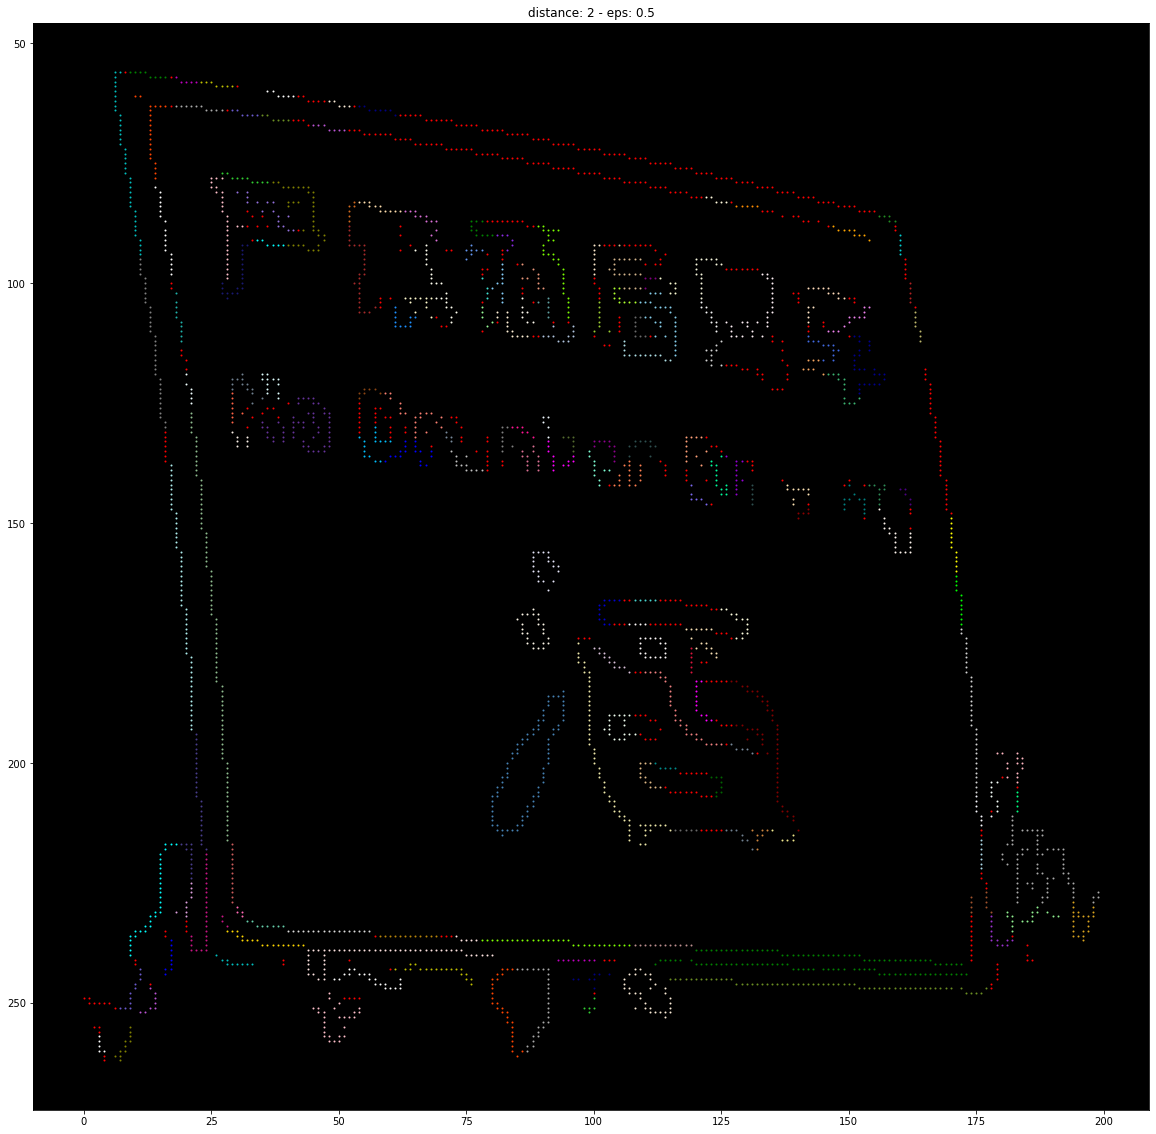

In [63]:
print_output_no_roi(clusters, pts, 'distance: {} - eps: {}'.format(d, eps), white=False)

# ADD RANDOM NOISE

In [77]:
# Noise Utils

def get_random(pts, qty_noise=1000, debug=False):
    noise = np.random.randint(low=(0, 0), high=(max(pts[:, 0]), max(pts[:, 1])), size=(qty_noise, 2))
    print("num of pts {}, num of noise {}".format(pts.shape[0], noise.shape[0]))
    noise_x = noise[:, 0]
    noise_y = noise[:, 1]

    if debug:
        plt.figure()
        plt.scatter(noise_x, noise_y)
        plt.title('Random Data')
    return noise

def add_random(pts, noise, debug=False):
    pts_new = pts.copy()
    pts_new = np.concatenate([pts_new, noise])
    if debug:
        print ("num of points with random {}".format(pts.shape[0]))
        plt.figure()
        plt.scatter(new_pts[:, 0], new_pts[:, 1])
        plt.title('Experiment Points')
    
    return pts_new

num of pts 4500, num of noise 1500
num of points: (6000, 2)


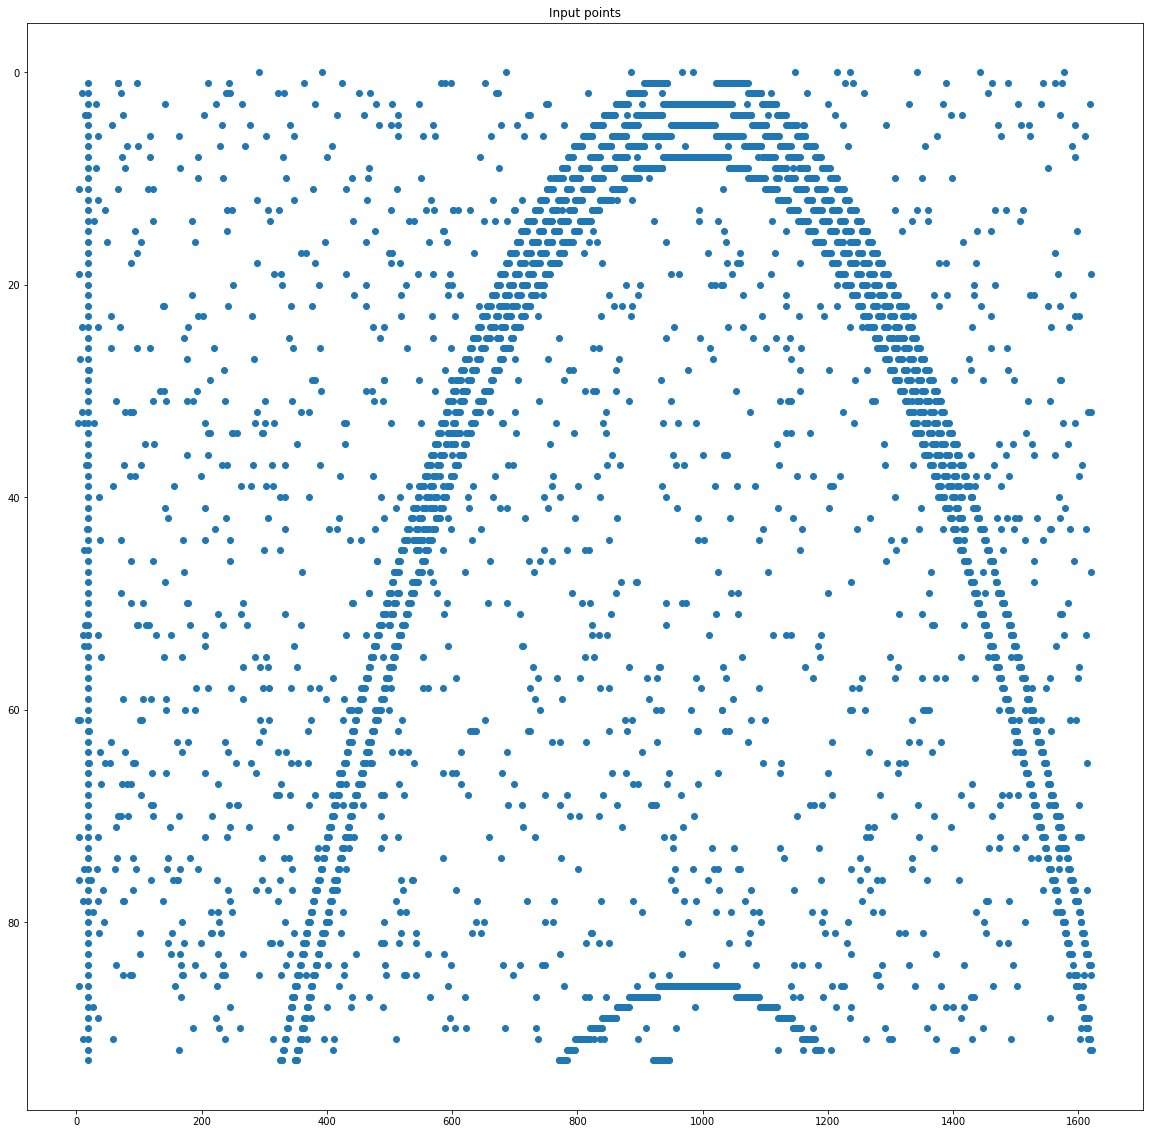

In [79]:
# get image
img_path = 'FullHD/18'
img = iread_edges('{}_canny.png'.format(img_path), resize_factor=None)
pts = get_pts(img)
pts = pts[:4500]

# add noise
noise = get_random(pts, 1500)
pts = add_random(pts, noise)
print_points(pts)


In [80]:
# get models
models = get_models_lines(pts, pts.shape[0]*2, roi_shape=img.shape, overwrite=True)

# get preference matrix
matrix = get_preference_matrix(pts, models, roi_shape=img.shape, step_debug=1000, debug=False)

0] took: 00 h 00 m 00 s
coords have same x [[1076    7]
 [1076   87]]


/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/home/ubuntu/.local/lib/python3.8/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


1000] took: 00 h 00 m 00 s
2000] took: 00 h 00 m 00 s
pts finished for sampling
Models Completed! total time: 00 h 00 m 00 s
0] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
1000] took: 00 h 00 m 00 s
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enough values to unpack (expected 2, got 1)
not enou

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 50 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 31 s
Clusters Completed! total time: 00 h 00 m 00 s


/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 30 s
Clusters Completed! total time: 00 h 00 m 00 s


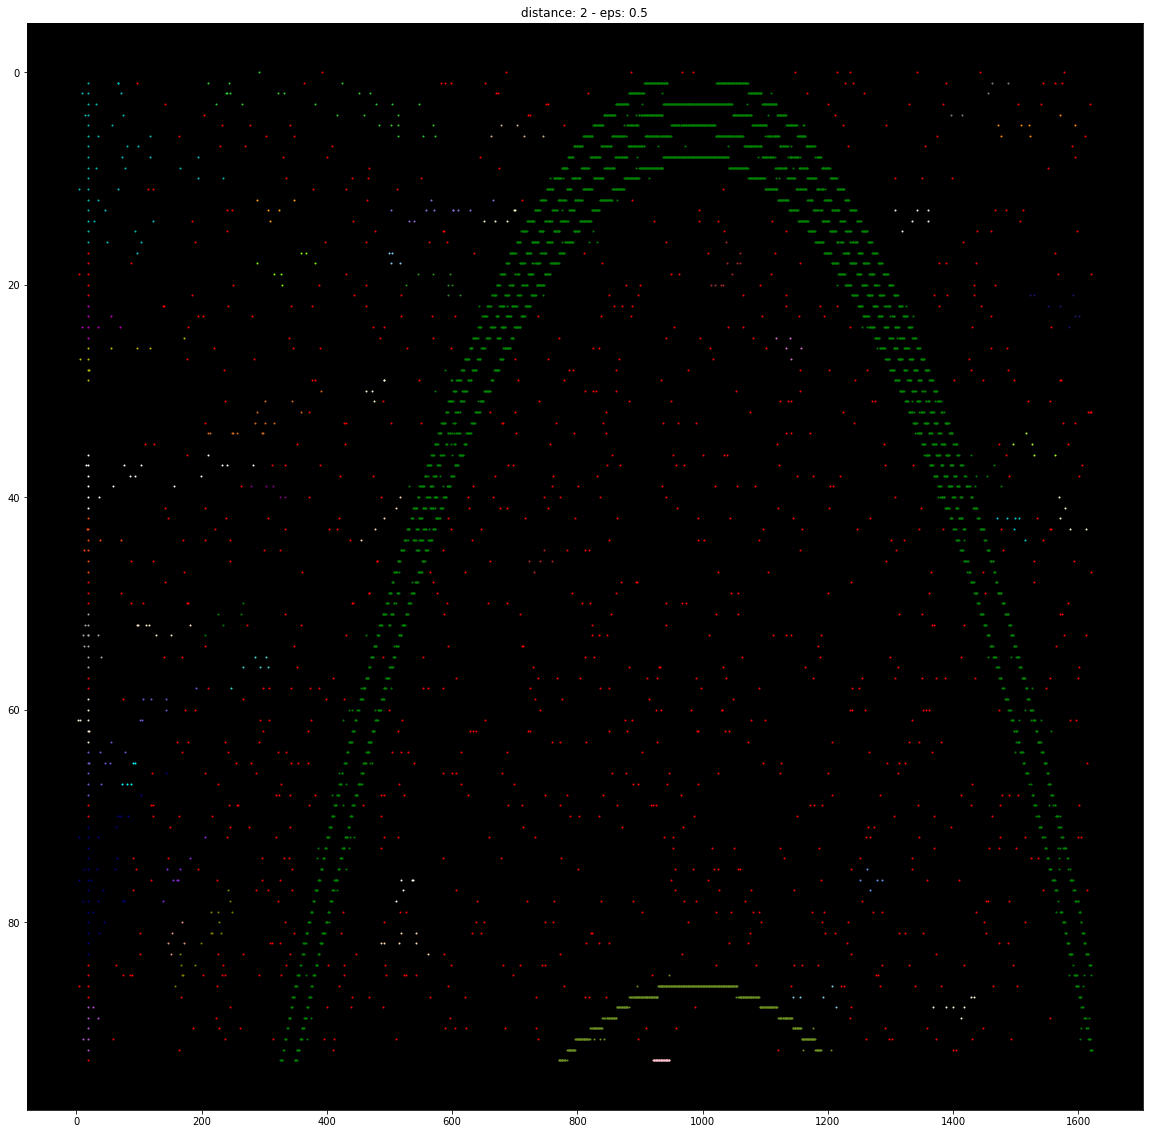

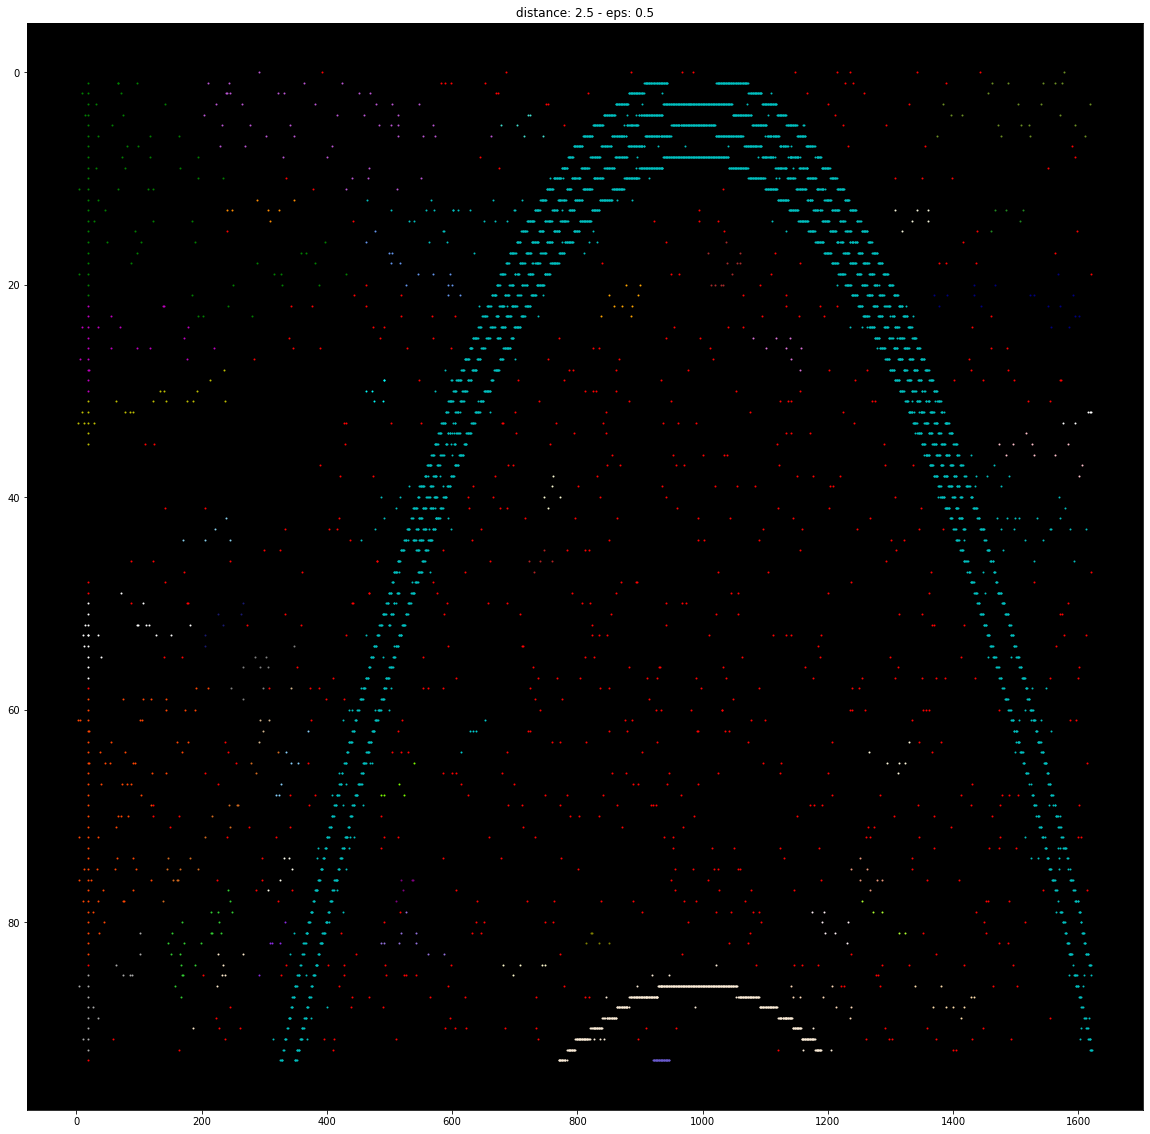

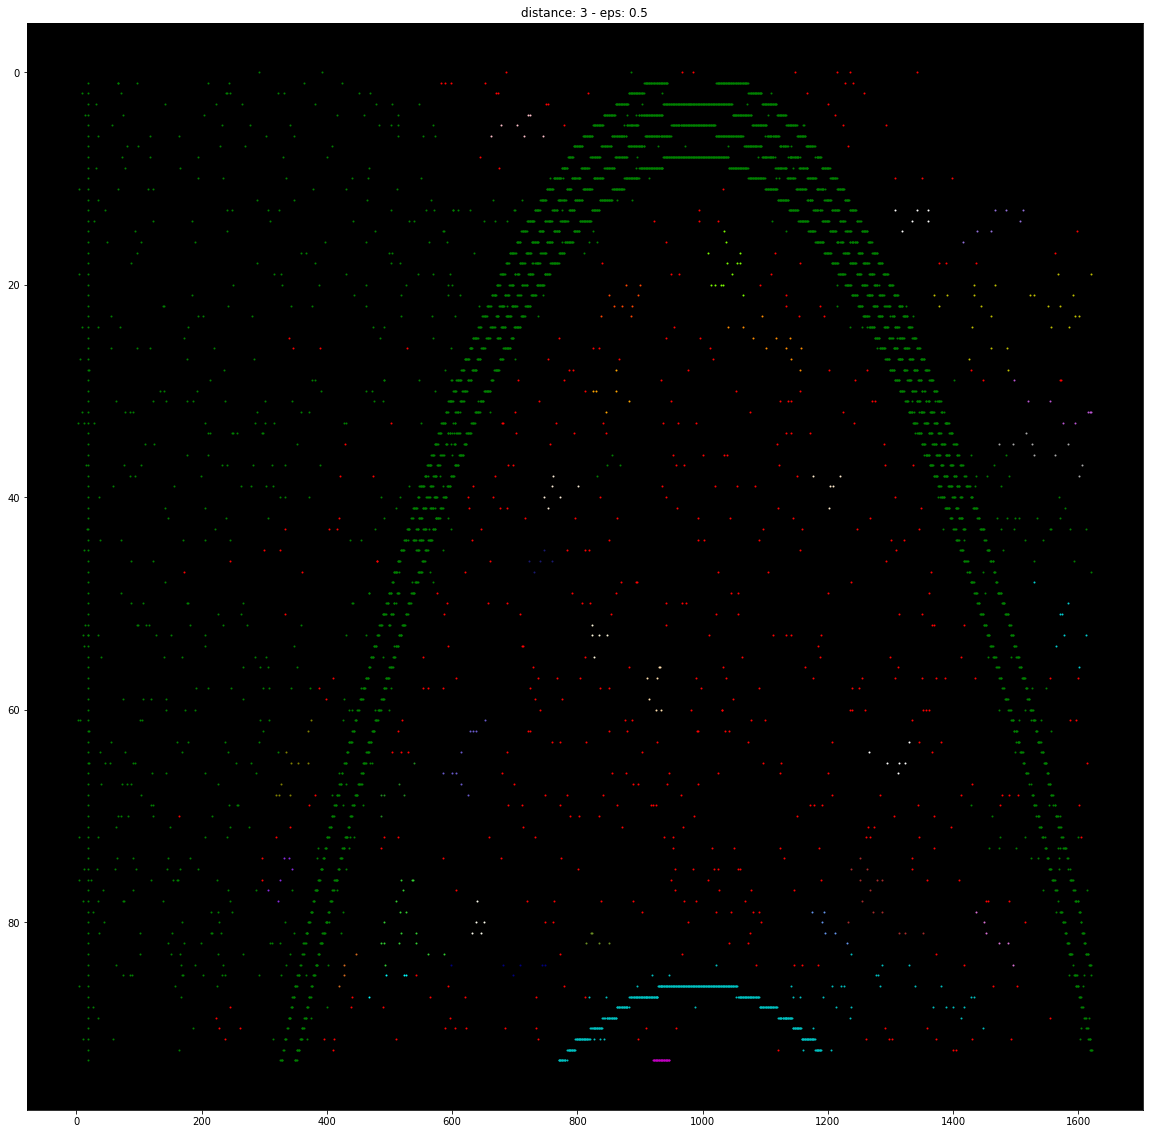

In [85]:
# get distance matrix - threshold = 2
for d in [2, 2.5, 3]:
    distance_matrix = get_distance_matrix_multithreaded(matrix, d)
    eps = 0.5
    clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, eps)
    print_output_no_roi(clusters, pts, 'distance: {} - eps: {}'.format(d, eps), white=False)

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1776: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Distance Matrix Completed! total time: 00 h 00 m 28 s
Clusters Completed! total time: 00 h 00 m 00 s
Clusters Completed! total time: 00 h 00 m 00 s
Clusters Completed! total time: 00 h 00 m 00 s
Clusters Completed! total time: 00 h 00 m 01 s
Clusters Completed! total time: 00 h 00 m 00 s
Clusters Completed! total time: 00 h 00 m 00 s


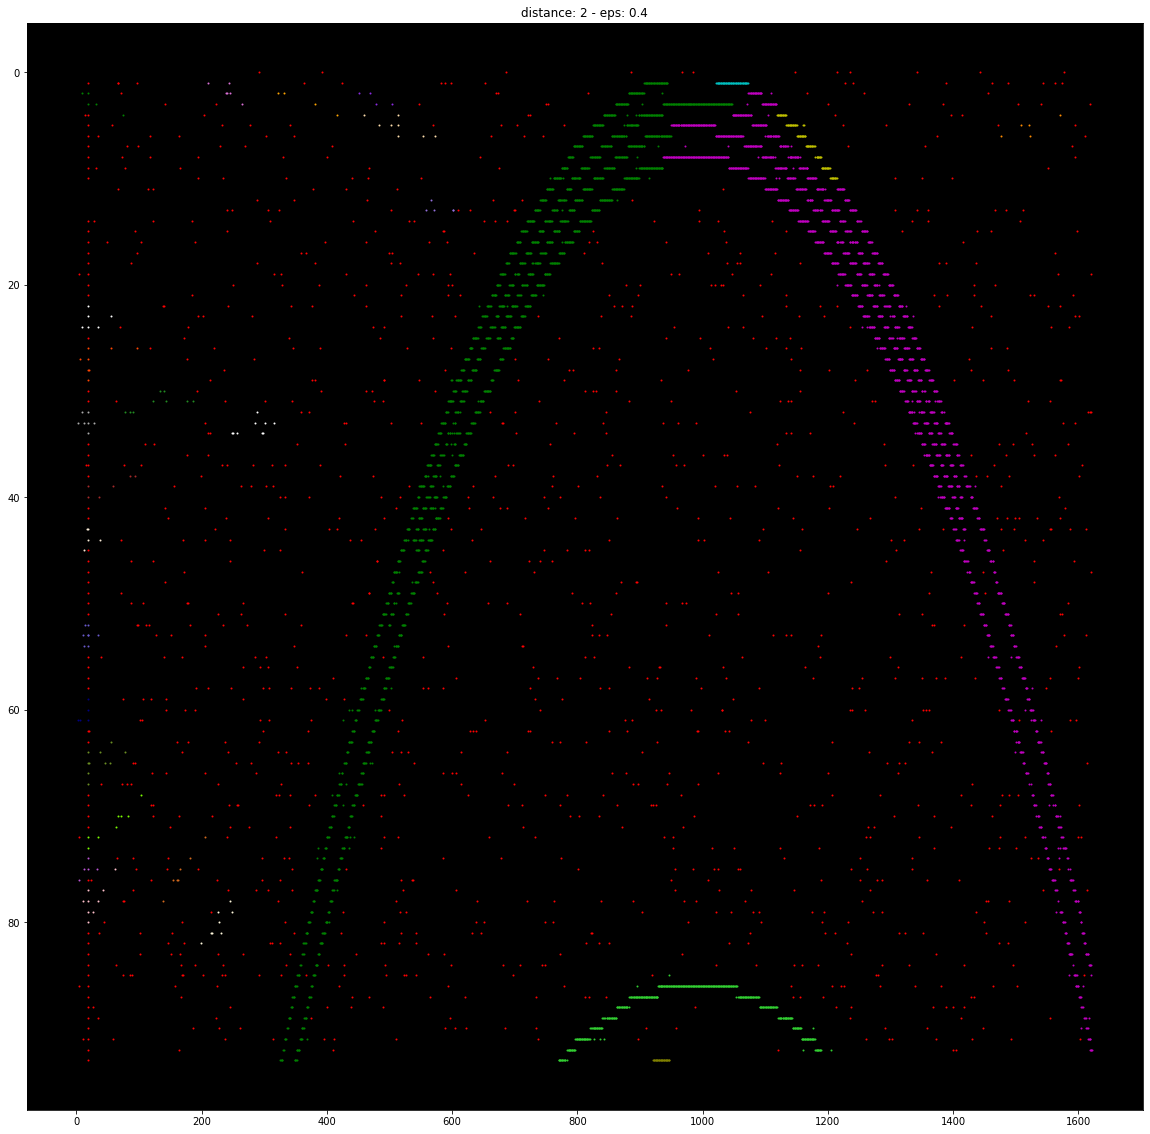

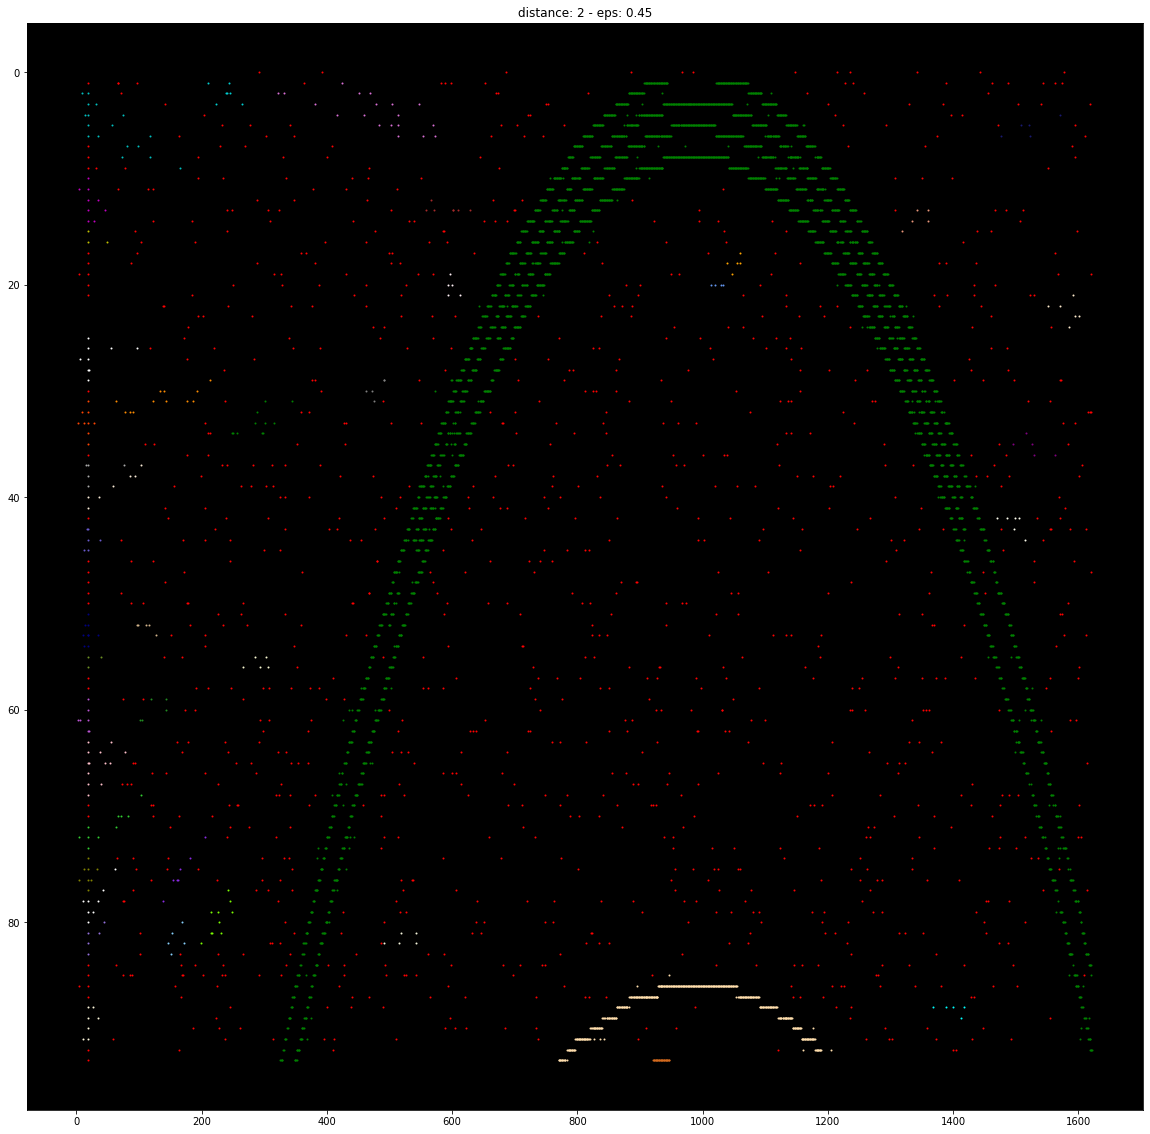

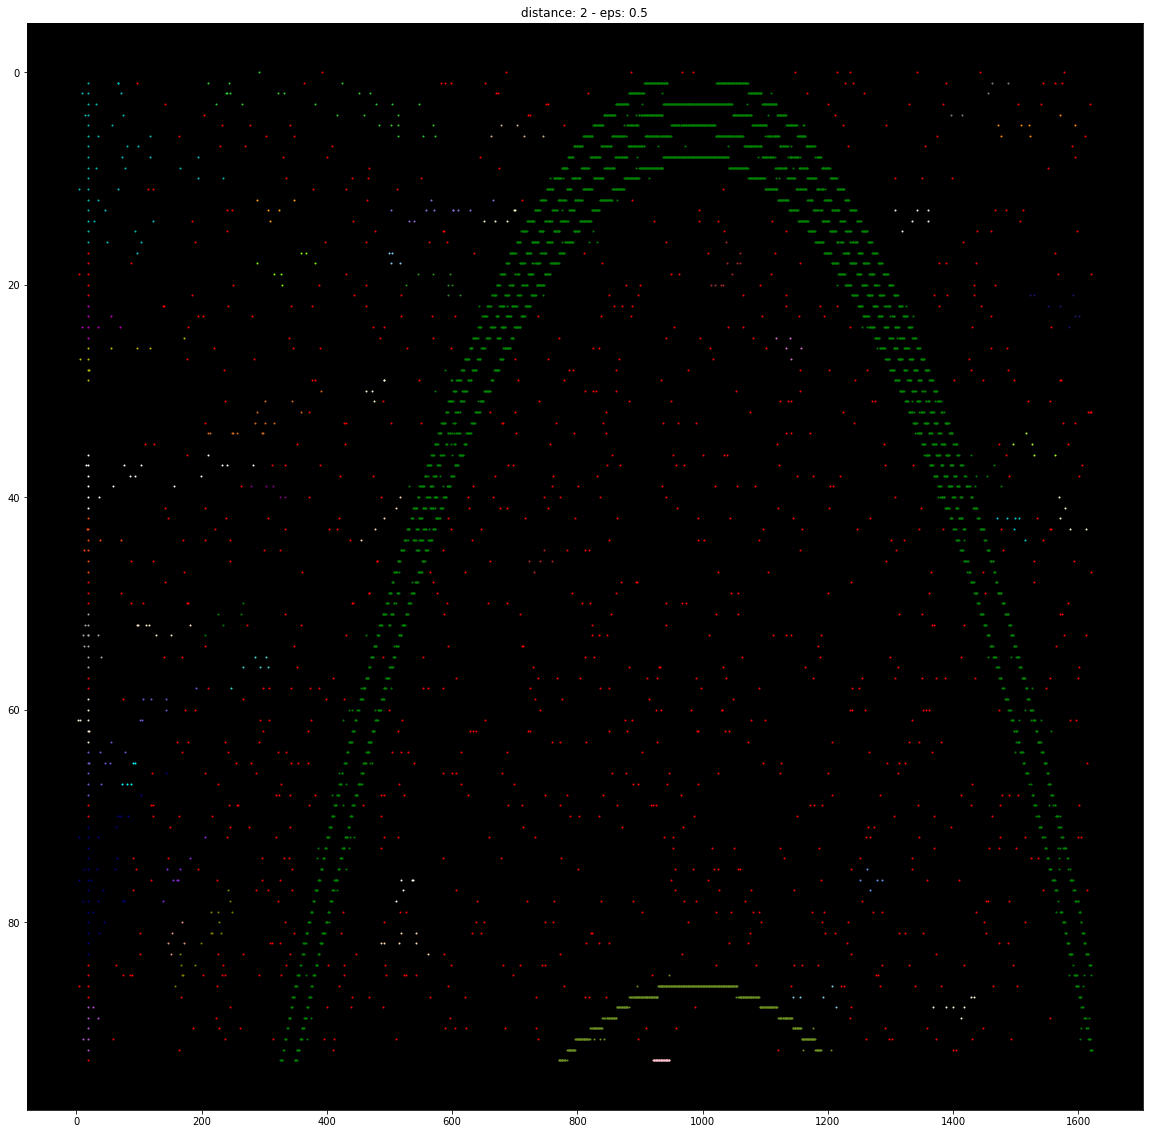

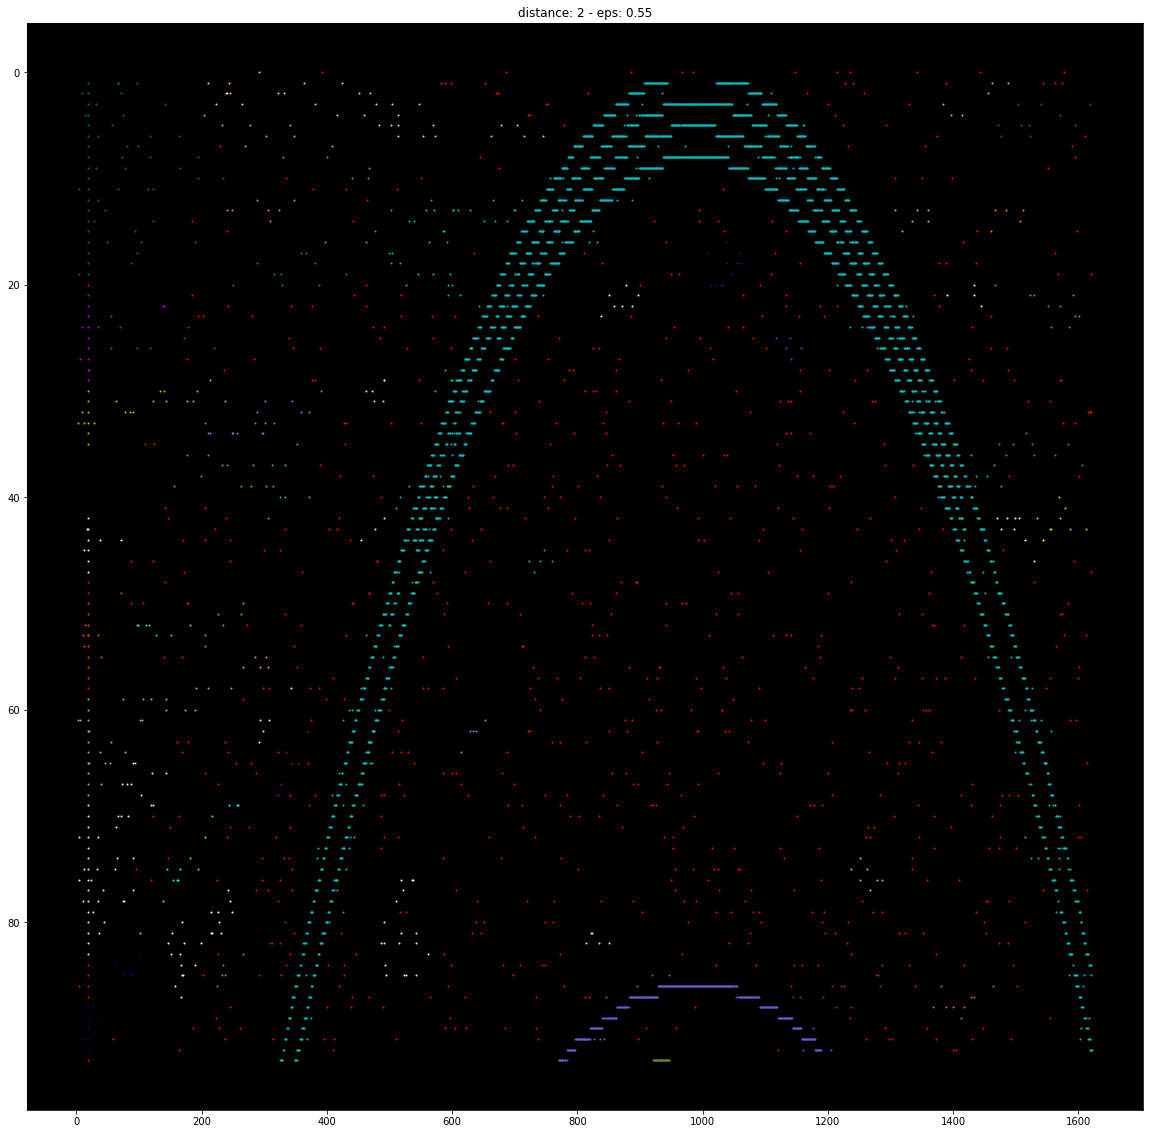

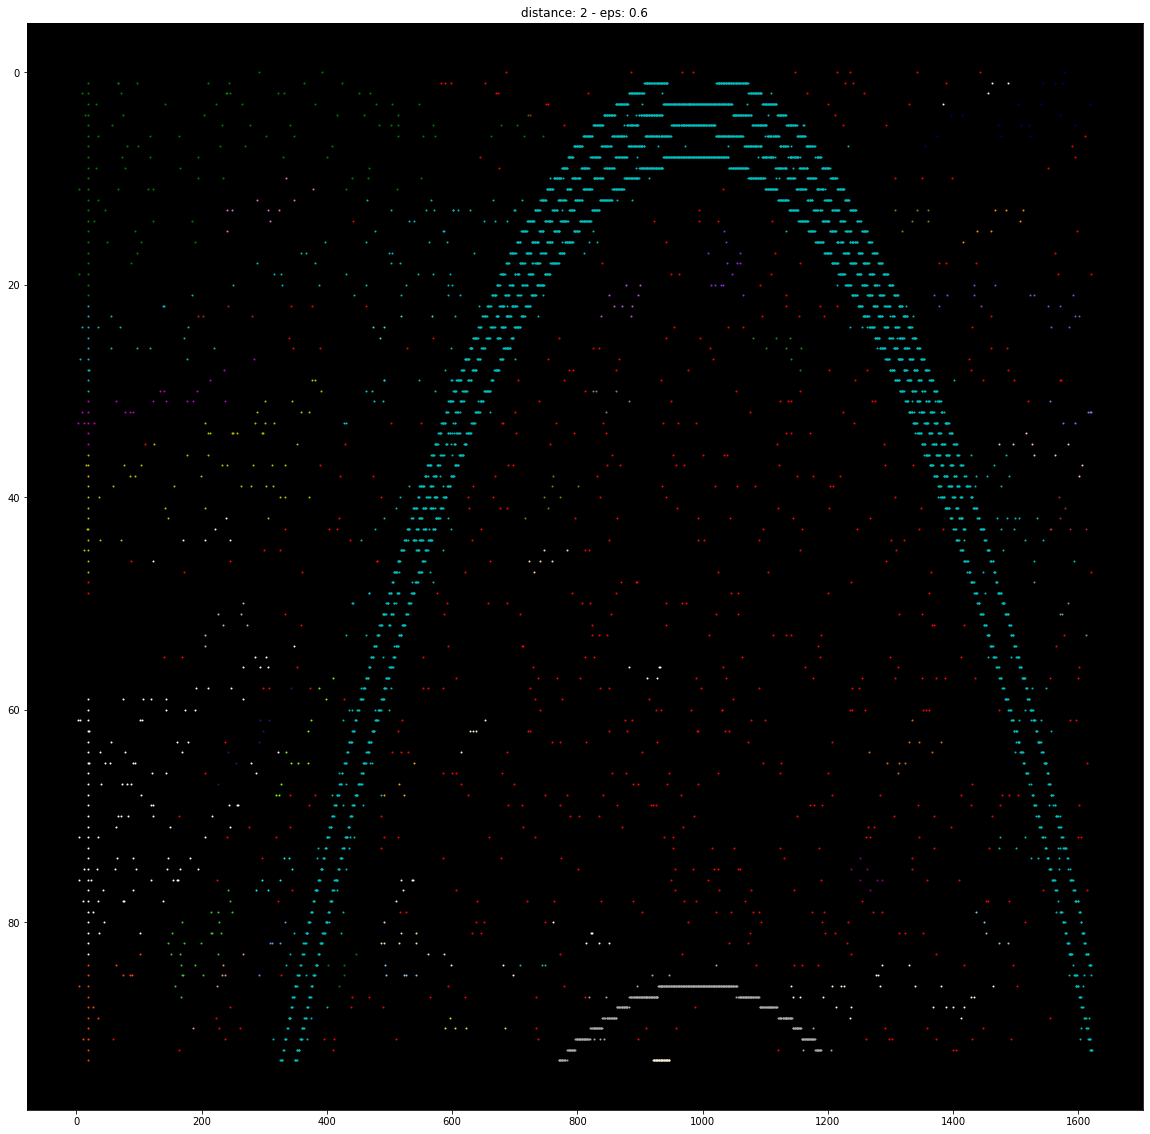

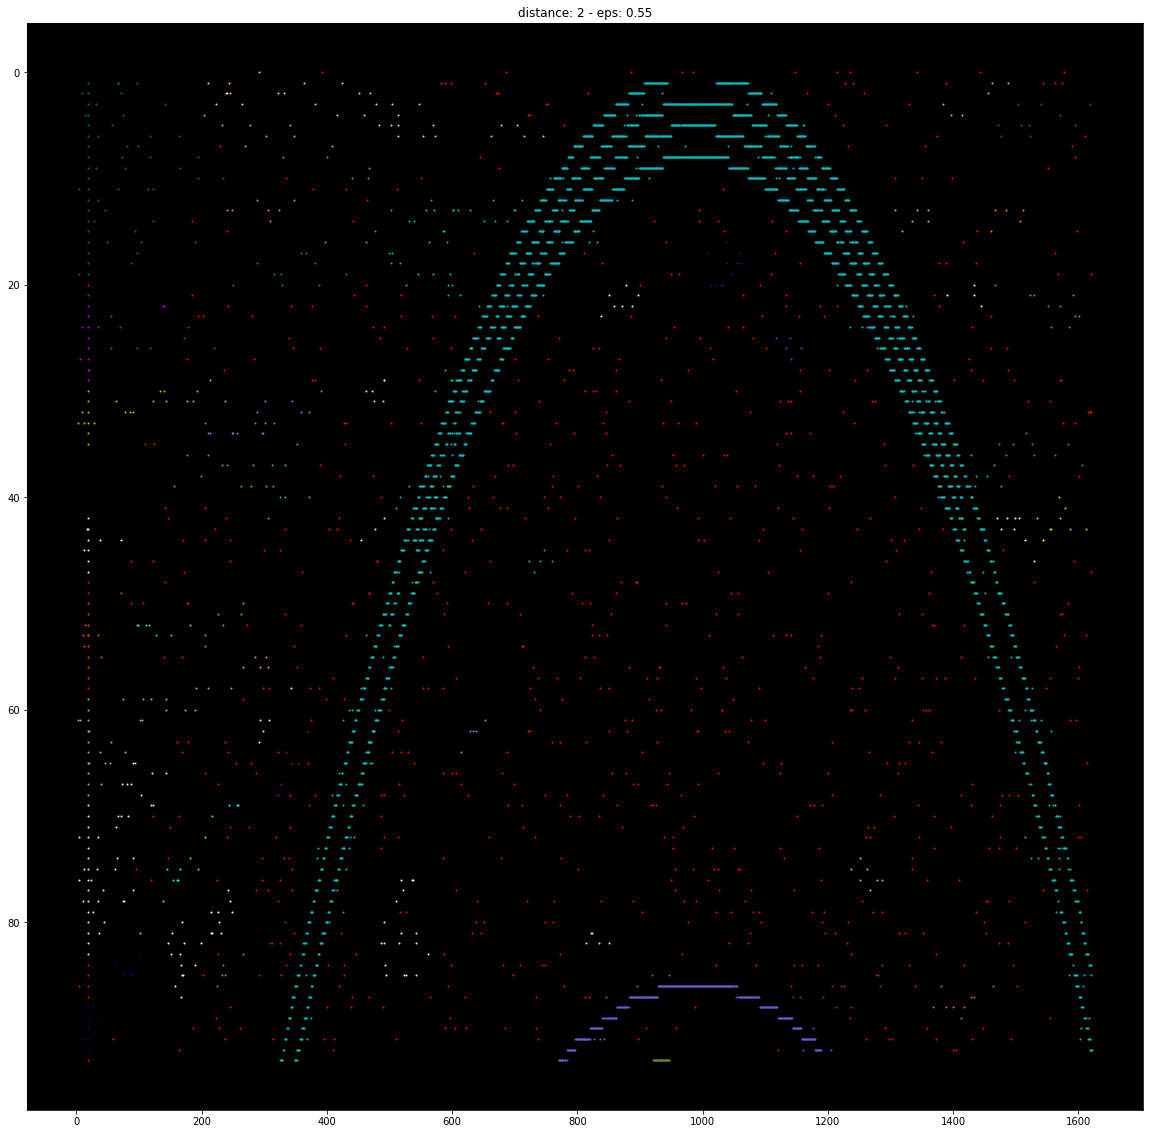

In [87]:
distance_matrix = get_distance_matrix_multithreaded(matrix, 2)

for eps in [0.4, 0.45, 0.5, 0.55, 0.6, 0.55]:
    clusters, clusters_label, pts_clusters = get_clusters_from_distance(distance_matrix, eps)
    print_output_no_roi(clusters, pts, 'distance: {} - eps: {}'.format(2, eps), white=False)